# Подготовка

Установка пакетов:
- torch, torchvision: для обучения нейронной сети,
- pandas: для чтения данных из CSV-таблицы,
- matplotlib, geopy, basemap: для построения графиков и карт,
- scikit-learn: инструменты статистики,
- tqdm: вспомогательная библиотека для отслеживания долгих циклов.

In [1]:
!pip install --upgrade torch torchvision tqdm pandas matplotlib scikit-learn geopy basemap
!pip install --upgrade "numpy<1.24"  # установка подходящей версии пакета numpy

ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'


Подключение необходимых пакетов:

In [2]:
import time  

import numpy as np    
import pandas as pd   
import torch          
from torch import nn, optim  
from torch.utils.data import TensorDataset, DataLoader  
from sklearn import preprocessing          
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt             
from mpl_toolkits.basemap import Basemap    
from tqdm import tqdm                        
from geopy.distance import distance, lonlat  
from sklearn.metrics import mean_squared_error
from numpy import sqrt
%matplotlib inline


# Работа с данными

Загрузка датасета из файла CSV, вывод общих сведений на экран:

In [3]:
atlantic = pd.read_csv('atlantic.csv', sep=',') 
atlantic  

ID                 Name      Date  Time Event Status Latitude  \
0      AL011851              UNNAMED  18510625     0           HU    28.0N   
1      AL011851              UNNAMED  18510625   600           HU    28.0N   
2      AL011851              UNNAMED  18510625  1200           HU    28.0N   
3      AL011851              UNNAMED  18510625  1800           HU    28.1N   
4      AL011851              UNNAMED  18510625  2100     L     HU    28.2N   
...         ...                  ...       ...   ...   ...    ...      ...   
49100  AL122015                 KATE  20151112  1200           EX    41.3N   
49101  AL122015                 KATE  20151112  1800           EX    41.9N   
49102  AL122015                 KATE  20151113     0           EX    41.5N   
49103  AL122015                 KATE  20151113   600           EX    40.8N   
49104  AL122015                 KATE  20151113  1200           EX    40.7N   

      Longitude  Maximum Wind  Minimum Pressure  ...  Low Wind SW  \
0         94.8W            80              -999  ...         -999   
1         95.4W            80              -999  ...         -999   
2         96.0W            80              -999  ...         -999   
3         96.5W            80              -999  ...         -999   
4         96.8W            80              -999  ...         -999   
...         ...           ...               ...  ...          ...   
49100     50.4W            55               981  ...          180   
49101     49.9W            55               983  ...          180   
49102     49.2W            50               985  ...          200   
49103     47.5W            45               985  ...          180   
49104     45.4W            45               987  ...          150   

       Low Wind NW  Moderate Wind NE  Moderate Wind SE  Moderate Wind SW  \
0             -999              -999              -999              -999   
1             -999              -999              -999              -999   
2             -999              -999              -999              -999   
3             -999              -999              -999              -999   
4             -999              -999              -999              -999   
...            ...               ...               ...               ...   
49100          120               120               120                60   
49101          120               120               120                60   
49102          220               120               120                60   
49103          220                 0                 0                 0   
49104          220                 0                 0                 0   

       Moderate Wind NW  High Wind NE  High Wind SE  High Wind SW  \
0                  -999          -999          -999          -999   
1                  -999          -999          -999          -999   
2                  -999          -999          -999          -999   
3                  -999          -999          -999          -999   
4                  -999          -999          -999          -999   
...                 ...           ...           ...           ...   
49100                 0             0             0             0   
49101                 0             0             0             0   
49102                 0             0             0             0   
49103                 0             0             0             0   
49104                 0             0             0             0   

       High Wind NW  
0              -999  
1              -999  
2              -999  
3              -999  
4              -999  
...             ...  
49100             0  
49101             0  
49102             0  
49103             0  
49104             0  

[49105 rows x 22 columns]

In [4]:
def transform_geo_float(val):  # функция преобразования географической координаты из строки в число
    num = float(val[:-1])      
    if val[-1] in ('S', 'W'): 
        num = -num            
    return num  

In [5]:
atlantic['Latitude'] = atlantic['Latitude'].apply(transform_geo_float)    
atlantic['Longitude'] = atlantic['Longitude'].apply(transform_geo_float)
atlantic

ID                 Name      Date  Time Event Status  Latitude  \
0      AL011851              UNNAMED  18510625     0           HU      28.0   
1      AL011851              UNNAMED  18510625   600           HU      28.0   
2      AL011851              UNNAMED  18510625  1200           HU      28.0   
3      AL011851              UNNAMED  18510625  1800           HU      28.1   
4      AL011851              UNNAMED  18510625  2100     L     HU      28.2   
...         ...                  ...       ...   ...   ...    ...       ...   
49100  AL122015                 KATE  20151112  1200           EX      41.3   
49101  AL122015                 KATE  20151112  1800           EX      41.9   
49102  AL122015                 KATE  20151113     0           EX      41.5   
49103  AL122015                 KATE  20151113   600           EX      40.8   
49104  AL122015                 KATE  20151113  1200           EX      40.7   

       Longitude  Maximum Wind  Minimum Pressure  ...  Low Wind SW  \
0          -94.8            80              -999  ...         -999   
1          -95.4            80              -999  ...         -999   
2          -96.0            80              -999  ...         -999   
3          -96.5            80              -999  ...         -999   
4          -96.8            80              -999  ...         -999   
...          ...           ...               ...  ...          ...   
49100      -50.4            55               981  ...          180   
49101      -49.9            55               983  ...          180   
49102      -49.2            50               985  ...          200   
49103      -47.5            45               985  ...          180   
49104      -45.4            45               987  ...          150   

       Low Wind NW  Moderate Wind NE  Moderate Wind SE  Moderate Wind SW  \
0             -999              -999              -999              -999   
1             -999              -999              -999              -999   
2             -999              -999              -999              -999   
3             -999              -999              -999              -999   
4             -999              -999              -999              -999   
...            ...               ...               ...               ...   
49100          120               120               120                60   
49101          120               120               120                60   
49102          220               120               120                60   
49103          220                 0                 0                 0   
49104          220                 0                 0                 0   

       Moderate Wind NW  High Wind NE  High Wind SE  High Wind SW  \
0                  -999          -999          -999          -999   
1                  -999          -999          -999          -999   
2                  -999          -999          -999          -999   
3                  -999          -999          -999          -999   
4                  -999          -999          -999          -999   
...                 ...           ...           ...           ...   
49100                 0             0             0             0   
49101                 0             0             0             0   
49102                 0             0             0             0   
49103                 0             0             0             0   
49104                 0             0             0             0   

       High Wind NW  
0              -999  
1              -999  
2              -999  
3              -999  
4              -999  
...             ...  
49100             0  
49101             0  
49102             0  
49103             0  
49104             0  

[49105 rows x 22 columns]

В других работах по данной теме учитывают также такие параметры:

- Месяц года (сезон),
- Час (время суток).

Считается, что поведение ураганов повторяется в один сезоны и в одно время суток. Поэтому введём дополнительные столбцы в датасет:

In [6]:
def parse_date(x):  # функция разбиения даты на компоненты
    ym, day = x // 100, x % 100  
    year, month = ym // 100, ym % 100  
    return year, month, day

def parse_time(x):
    hour, minute = x // 100, x % 100
    return hour, minute

atlantic['Month'] = atlantic['Date'].apply(lambda x: parse_date(x)[1])  
atlantic['Hour'] = atlantic['Time'].apply(lambda x: parse_time(x)[0]) 
atlantic 

ID                 Name      Date  Time Event Status  Latitude  \
0      AL011851              UNNAMED  18510625     0           HU      28.0   
1      AL011851              UNNAMED  18510625   600           HU      28.0   
2      AL011851              UNNAMED  18510625  1200           HU      28.0   
3      AL011851              UNNAMED  18510625  1800           HU      28.1   
4      AL011851              UNNAMED  18510625  2100     L     HU      28.2   
...         ...                  ...       ...   ...   ...    ...       ...   
49100  AL122015                 KATE  20151112  1200           EX      41.3   
49101  AL122015                 KATE  20151112  1800           EX      41.9   
49102  AL122015                 KATE  20151113     0           EX      41.5   
49103  AL122015                 KATE  20151113   600           EX      40.8   
49104  AL122015                 KATE  20151113  1200           EX      40.7   

       Longitude  Maximum Wind  Minimum Pressure  ...  Moderate Wind NE  \
0          -94.8            80              -999  ...              -999   
1          -95.4            80              -999  ...              -999   
2          -96.0            80              -999  ...              -999   
3          -96.5            80              -999  ...              -999   
4          -96.8            80              -999  ...              -999   
...          ...           ...               ...  ...               ...   
49100      -50.4            55               981  ...               120   
49101      -49.9            55               983  ...               120   
49102      -49.2            50               985  ...               120   
49103      -47.5            45               985  ...                 0   
49104      -45.4            45               987  ...                 0   

       Moderate Wind SE  Moderate Wind SW  Moderate Wind NW  High Wind NE  \
0                  -999              -999              -999          -999   
1                  -999              -999              -999          -999   
2                  -999              -999              -999          -999   
3                  -999              -999              -999          -999   
4                  -999              -999              -999          -999   
...                 ...               ...               ...           ...   
49100               120                60                 0             0   
49101               120                60                 0             0   
49102               120                60                 0             0   
49103                 0                 0                 0             0   
49104                 0                 0                 0             0   

       High Wind SE  High Wind SW  High Wind NW  Month  Hour  
0              -999          -999          -999      6     0  
1              -999          -999          -999      6     6  
2              -999          -999          -999      6    12  
3              -999          -999          -999      6    18  
4              -999          -999          -999      6    21  
...             ...           ...           ...    ...   ...  
49100             0             0             0     11    12  
49101             0             0             0     11    18  
49102             0             0             0     11     0  
49103             0             0             0     11     6  
49104             0             0             0     11    12  

[49105 rows x 24 columns]

In [7]:
atlantic['Next Minimum Pressure'] = atlantic.groupby('ID')['Minimum Pressure'].shift(-1)
atlantic['Next Maximum Wind Speed'] = atlantic.groupby('ID')['Maximum Wind'].shift(-1)

last_rows = atlantic.groupby('ID').tail(1).index
atlantic.loc[last_rows, 'Next Minimum Pressure'] = 0
atlantic.loc[last_rows, 'Next Maximum Wind Speed'] = 0

atlantic

ID                 Name      Date  Time Event Status  Latitude  \
0      AL011851              UNNAMED  18510625     0           HU      28.0   
1      AL011851              UNNAMED  18510625   600           HU      28.0   
2      AL011851              UNNAMED  18510625  1200           HU      28.0   
3      AL011851              UNNAMED  18510625  1800           HU      28.1   
4      AL011851              UNNAMED  18510625  2100     L     HU      28.2   
...         ...                  ...       ...   ...   ...    ...       ...   
49100  AL122015                 KATE  20151112  1200           EX      41.3   
49101  AL122015                 KATE  20151112  1800           EX      41.9   
49102  AL122015                 KATE  20151113     0           EX      41.5   
49103  AL122015                 KATE  20151113   600           EX      40.8   
49104  AL122015                 KATE  20151113  1200           EX      40.7   

       Longitude  Maximum Wind  Minimum Pressure  ...  Moderate Wind SW  \
0          -94.8            80              -999  ...              -999   
1          -95.4            80              -999  ...              -999   
2          -96.0            80              -999  ...              -999   
3          -96.5            80              -999  ...              -999   
4          -96.8            80              -999  ...              -999   
...          ...           ...               ...  ...               ...   
49100      -50.4            55               981  ...                60   
49101      -49.9            55               983  ...                60   
49102      -49.2            50               985  ...                60   
49103      -47.5            45               985  ...                 0   
49104      -45.4            45               987  ...                 0   

       Moderate Wind NW  High Wind NE  High Wind SE  High Wind SW  \
0                  -999          -999          -999          -999   
1                  -999          -999          -999          -999   
2                  -999          -999          -999          -999   
3                  -999          -999          -999          -999   
4                  -999          -999          -999          -999   
...                 ...           ...           ...           ...   
49100                 0             0             0             0   
49101                 0             0             0             0   
49102                 0             0             0             0   
49103                 0             0             0             0   
49104                 0             0             0             0   

       High Wind NW  Month  Hour  Next Minimum Pressure  \
0              -999      6     0                 -999.0   
1              -999      6     6                 -999.0   
2              -999      6    12                 -999.0   
3              -999      6    18                 -999.0   
4              -999      6    21                 -999.0   
...             ...    ...   ...                    ...   
49100             0     11    12                  983.0   
49101             0     11    18                  985.0   
49102             0     11     0                  985.0   
49103             0     11     6                  987.0   
49104             0     11    12                    0.0   

       Next Maximum Wind Speed  
0                         80.0  
1                         80.0  
2                         80.0  
3                         80.0  
4                         70.0  
...                        ...  
49100                     55.0  
49101                     50.0  
49102                     45.0  
49103                     45.0  
49104                      0.0  

[49105 rows x 26 columns]

In [8]:
atlantic.replace(-999, 0, inplace=True)
atlantic

ID                 Name      Date  Time Event Status  Latitude  \
0      AL011851              UNNAMED  18510625     0           HU      28.0   
1      AL011851              UNNAMED  18510625   600           HU      28.0   
2      AL011851              UNNAMED  18510625  1200           HU      28.0   
3      AL011851              UNNAMED  18510625  1800           HU      28.1   
4      AL011851              UNNAMED  18510625  2100     L     HU      28.2   
...         ...                  ...       ...   ...   ...    ...       ...   
49100  AL122015                 KATE  20151112  1200           EX      41.3   
49101  AL122015                 KATE  20151112  1800           EX      41.9   
49102  AL122015                 KATE  20151113     0           EX      41.5   
49103  AL122015                 KATE  20151113   600           EX      40.8   
49104  AL122015                 KATE  20151113  1200           EX      40.7   

       Longitude  Maximum Wind  Minimum Pressure  ...  Moderate Wind SW  \
0          -94.8            80                 0  ...                 0   
1          -95.4            80                 0  ...                 0   
2          -96.0            80                 0  ...                 0   
3          -96.5            80                 0  ...                 0   
4          -96.8            80                 0  ...                 0   
...          ...           ...               ...  ...               ...   
49100      -50.4            55               981  ...                60   
49101      -49.9            55               983  ...                60   
49102      -49.2            50               985  ...                60   
49103      -47.5            45               985  ...                 0   
49104      -45.4            45               987  ...                 0   

       Moderate Wind NW  High Wind NE  High Wind SE  High Wind SW  \
0                     0             0             0             0   
1                     0             0             0             0   
2                     0             0             0             0   
3                     0             0             0             0   
4                     0             0             0             0   
...                 ...           ...           ...           ...   
49100                 0             0             0             0   
49101                 0             0             0             0   
49102                 0             0             0             0   
49103                 0             0             0             0   
49104                 0             0             0             0   

       High Wind NW  Month  Hour  Next Minimum Pressure  \
0                 0      6     0                    0.0   
1                 0      6     6                    0.0   
2                 0      6    12                    0.0   
3                 0      6    18                    0.0   
4                 0      6    21                    0.0   
...             ...    ...   ...                    ...   
49100             0     11    12                  983.0   
49101             0     11    18                  985.0   
49102             0     11     0                  985.0   
49103             0     11     6                  987.0   
49104             0     11    12                    0.0   

       Next Maximum Wind Speed  
0                         80.0  
1                         80.0  
2                         80.0  
3                         80.0  
4                         70.0  
...                        ...  
49100                     55.0  
49101                     50.0  
49102                     45.0  
49103                     45.0  
49104                      0.0  

[49105 rows x 26 columns]

Определим класс для нормирования числовых данных (приведение произовльных диапазонов к диапазону \[0, 1\] по наименьшему/наибольшему значению в каждом столбце):

In [9]:
class Norm():  # класс для нормирования числовых данных и хранения коэффициентов нормировки
    def __init__(self):  
        self.scaler = preprocessing.MinMaxScaler()  
    
    def normalize_df(self, df_train, df_val, df_test, fields):  # функция нормирования 3 подвыборок (обучающая, валидационная, тестовая) с сохранением параметров нормирования обучающей подвыборки, причём нормируются только заданные столбцы fields
        tr = df_train.copy(deep=True)  
        va = df_val.copy(deep=True)   
        te = df_test.copy(deep=True)
        
        a = tr[fields].values
        b = va[fields].values 
        c = te[fields].values

        a = self.scaler.fit_transform(a)
        b = self.scaler.transform(b)      
        c = self.scaler.transform(c)      
        
        tr.loc[:, fields] = a  
        va.loc[:, fields] = b 
        te.loc[:, fields] = c  
        
        def shift_angle(angle):  # исправление значения угла "широты"
            if angle > 90:  
                return angle - 180  
            return angle  
        
        tr['Latitude'] = tr['Latitude'].apply(shift_angle)  
        va['Latitude'] = va['Latitude'].apply(shift_angle)  
        te['Latitude'] = te['Latitude'].apply(shift_angle)  
        return tr, va, te
    
    def unnormalize(self, data):  # денормализация данных в исходный диапазон значений
        scale = preprocessing.MinMaxScaler() 
        scale.min_, scale.scale_ = self.scaler.min_, self.scaler.scale_ 
        return scale.inverse_transform(data) 

Определим функцию для разбиения данных на обучающую, валидационную и тестовую подвыборки по заданному соотношению долей.

Разбиение проводится по подвыборкам (ураганам), а в каждом урагане может иметься различное число замеров параметров. Поэтому фактическая длина подвыборок (по замерам) может немного отличаться от заданного соотношения.

In [10]:
def split_data(df, storm_list, train_percent, val_percent): 
    storm_size = len(storm_list)  
    train_size = int(storm_size * train_percent)
    train_ids = storm_list[:train_size] 
    val_size = int(storm_size * val_percent) 
    val_ids = storm_list[train_size:(train_size + val_size)] 
    test_ids = storm_list[(train_size + val_size):] 
    
    train_data = df.loc[df['ID'].isin(train_ids)] 
    val_data = df.loc[df['ID'].isin(val_ids)]     
    test_data = df.loc[df['ID'].isin(test_ids)]  
    return (train_data, val_data, test_data), (train_ids, val_ids, test_ids)

Определим функцию для получения числовых тензоров из формата таблицы Pandas в виде NumPy-массивов.

In [11]:
max_series_len = 100  # маскимальная длина 

def get_float_data(storm_ids, df, fields): 
    storms_data, storms_labels = [], [] 
    
    for storm in tqdm(storm_ids):
        st_data, st_labels = [], []  
        cur_storm = df.loc[df.ID == storm]  
        cur_storm = cur_storm.sort_values(by=['Date', 'Time']) 
        cur_storm.reset_index(drop=True, inplace=True)  
        next_step = cur_storm.copy(deep=True)  
        lat_col = list(next_step.columns).index('Latitude')  
        long_col = list(next_step.columns).index('Longitude') 
        next_step.iloc[:-1, [lat_col, long_col]] = next_step.iloc[1:, [lat_col, long_col]].values
        for x in range(len(cur_storm)):  
            storm_series = cur_storm.loc[x, fields].values 
            storm_location = next_step.loc[x, ['Latitude', 'Longitude']].values 
            st_data.append(storm_series) 
            st_labels.append(storm_location)  
        for y in range(max_series_len - len(st_data)):
            zeros = np.zeros(len(fields)) 
            zeros_labels = np.zeros(2)
            st_data.append(zeros) 
            st_labels.append(zeros_labels)
        st_data = st_data[:max_series_len]  
        st_labels = st_labels[:max_series_len]  
        storms_data.append(st_data)  
        storms_labels.append(st_labels) 
    
    storms_data = np.array(storms_data, dtype=np.float32)  
    storms_labels = np.array(storms_labels, dtype=np.float32)
    return storms_data, storms_labels  # возврат массивов последовательностей (входные признаки, выходные метки)

## Модель машинного обучения

Определим модель для предсказания движения ураганов со следующей структурой:

1. Один LSTM-модуль с заданной глубиной и заданным количеством промежуточных признаков,
2. Один полносвязный слой, принимающий выходной тензор из LSTM-модуля.

На выходе нет функции активации, так как предполагается, что модель освоит диапазон данных на выходе на этапе обучения.

## Описание работы модели на базе LSTM

В данной работе создаётся модель машинного обучения, содержащая блок LSTM.

LSTM -- кратковременная долгосрочная память, блок нейронных сетей, которых содержит сравнительно небольшое хранилище для информации, и применяемый повторно на последовательности данных по правилу:

$$
            i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
            f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
            g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
            o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
            c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
            h_t = o_t \odot \tanh(c_t)
$$

, где:

- $h_t$ -- вектор скрытого состояния в момент времени $t$,
- $c_t$ -- состояние ячейка в момент времени $t$,
- $x_t$ -- вектор входных признаков в момент времени $t$,
- $h_{t-1}$ -- вектор скрытого состояния в предыдущий момент времени $t-1$ или в начальный момент времени $0$,
- $i_t, f_t, g_t, o_t$ -- векторы входа, забывания, ячейки и выходного шлюза в момент времени $t$,
- $\sigma$ -- функция сигмоида,
- $\odot$ -- знак произведения Адамара.

Блок LSTM пприменяется повторно для всех элементов последовательности, после чего выполняется обратное распространение ошибки. Это позволяет построить длинный путь для распространения ошибки с последовательным доуточнением внутренних матриц блока LSTM (путь длиннее, чем для классических нейронных сетей с полносвязными слоями и рекуррентных сетей с фиксиорованной глубиной).

Блок LSTM применяется в составе следующей модели:

- 2 блока LSTM,
- полносвязный слой внутренней размерности,
- полносвязный слой выходной размерности.

Внутрення размерность больше количества входных признаков и больше количества выходных признаков. Это соответствует отображению входной последовательности в простарнство большей размерности для выявления новых закономерностей.

Так как на входе и выходе есть географические координаты на соседних шагах, такая структура позволяет запоминать изменение координат в зависимости от предыдущих координат (типовые ветра и движения ураганов), а также от текущих признаков (некоторая поправка к частым ветрам).

Для обучения нужен массив размерности (K, M, N) входных последовательностей размерности (M, N) и массив размерности (K, M, P) выходных последовательностей (M, P), где:

- K -- количество обучающих примеров,
- M -- длина одной последовательности (количество шагов времени),
- N -- количество признаков на 1 шаге времени,
- P -- количество предсказываемых признаков на 1 шаге времени.

В процессе обучения модели требуется сопоставлять входные и выходные последовательности, для чего её подаются тензоры размерности in=(B, M, N), получаются тензоры pred=(B, M, P), и вычисляется значение ошибки loss=loss_fn(pred, gt), где:

- in -- пачка входных последовательностей (B штук последовательностей),
- pred -- пачка предсказанных выходных последоватлеьностей меток,
- gt (B, M, P) -- пачка заранее известных выходных последоватлеьностей меток.

In [12]:
class HU_LSTM(nn.Module):  
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, device): 
        # input_dim -- количество входных признаков,
        # hidden_dim -- количество промежуточных признаков (внутри блока LSTM и в полносвязных слоях),
        # layer_dim -- количество слоёв блока LSTM,
        # output_dim -- количество выходных признаков,
        # Длина последовательности не требуется дли инициализации модели
        super(HU_LSTM, self).__init__()  
        self.hidden_dim = hidden_dim  
        self.layer_dim = layer_dim  
        self.device = device  
        
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)  # инициализация блока LSTM (1)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim // 2, layer_dim, batch_first=True)  # инициализация блока LSTM (2)
        self.fc1 = nn.Linear(hidden_dim // 2, hidden_dim // 4) 
        self.fc2 = nn.Linear(hidden_dim // 4, output_dim) 
    
    def forward(self, x):  
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device)  
        out, (hn, cn) = self.lstm1(x, (h0, c0))
        
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim // 2).to(self.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim // 2).to(self.device) 
        out, (hn, cn) = self.lstm2(out, (h0, c0))
        
        out = self.fc1(out)  
        out = self.fc2(out)
        return out

Определим также вспомогательный класс для работы с моделью:

- Обучающий цикл,
- Функция валидации модели (на этапе обучения),
- Функция инференса (получения предсказаний) и оценки качества на тестовых данных,
- Функция расчёта погрешности измерения расстояния (пересчёт из географических координат в километры),
- Вывод графика изменения ошибки на этапе обучения,
- Сохранение весов обученной модели в файл.

In [13]:
class LSTM_Handler: 
    def __init__(self, model, loss_fn, optimizer, scheduler):
        # model -- объект модели, которую требуется обучить,
        self.model = model         
        self.loss_fn = loss_fn     
        self.optimizer = optimizer 
        self.scheduler = scheduler 
        self.train_losses, self.val_losses = [], []  
        self.distances = []
        
    def train(  
        self,   
        train_loader, 
        val_loader=None,  
        batch_size=100,   
        n_epochs=15,     
        eval_step=100,    
        clip_loss=100.0
    ):
        self.train_losses, self.val_losses = [], [] 
        self.distances = []  
        
        pbar = tqdm(range(n_epochs), leave=True)  
        for epoch in pbar:  # цикл по эпохам
            epoch_losses = []  
    
            for data, target in train_loader:  # цикл по пачкам
                self.optimizer.zero_grad()  
                y_pd = self.predict(data)   
                y_pd = y_pd.view(-1, 2)     # приведение размерности предсказаний к (B*M, P) для корректного расчёта ошибки
                y_gt = target.view(-1, 2)    

                loss = self.loss_fn(y_pd, y_gt)    
                loss = torch.clip(loss, 0, clip_loss)  
                epoch_losses.append(loss.item())   
                
                loss.backward()  
                self.optimizer.step()
            
            train_loss = np.mean(epoch_losses) 
            self.train_losses.append(train_loss) 

            self.validation(val_loader) 
            self.scheduler.step(self.val_losses[-1])  

            pbar.set_description('train loss={:.6f}, val loss={:.6f}'
                                 .format(train_loss, self.val_losses[-1]))  
            if epoch % eval_step == eval_step - 1:  
                mean_distance_error = self.distance_error(val_loader)  
                self.distances.append(mean_distance_error)  

    def predict(self, x_data):  
        y_pred = self.model(x_data) 
        return y_pred  

    def validation(self, val_loader): 
        if val_loader is None:
            return  # вернуться
        with torch.no_grad():  
            val_losses = []  
            for data, target in val_loader: 
                y_pred = self.model(data)  
                for k in range(data.shape[0]):  
                    elem_pd, elem_gt = y_pred[k], target[k] 
                    loss = self.loss_fn(elem_pd, elem_gt)  
                    val_losses.append(loss.item())  
            self.val_losses.append(np.mean(val_losses))  

    def evaluate(self, test_loader, seq_len=150):  
        with torch.no_grad():  
            test_losses = [] 
            actual, predicted = [], [] 
            for data, target in test_loader:  
                y_pd = self.model(data)  
                for k in range(data.shape[0]):  
                    elem_pd, elem_gt = y_pd[k], target[k] 
                    loss = self.loss_fn(elem_pd, elem_gt)  
                    test_losses.append(loss.item())  
                
                y_pd = y_pd.view(-1, 2)  
                y_gt = target.view(-1, 2)  
                y_pd = y_pd.cpu().detach().numpy()  
                y_gt = y_gt.cpu().detach().numpy() 
                actual.append(y_gt)  
                predicted.append(y_pd) 
    
            # test_loss = np.mean(test_losses)  # расчёт среднего значения ошибки по пачкам
            actual = np.concatenate(actual, axis=0)  # объединение всех предсказаний в один плоский массив
            predicted = np.concatenate(predicted, axis=0)  
            actual3d = np.reshape(actual, (-1, seq_len, 2))  # преобразование размерности предсказаний к прежнему виду с последовательностями по ураганам
            predicted3d = np.reshape(predicted, (-1, seq_len, 2))  
            return actual3d, predicted3d, test_losses  # возврат предскзааний, правильных данных и значения ошибки

    def distance_error(self, val_loader):  # расчёт ошибки определения расстояния в км на валидационной выборке
        with torch.no_grad(): 
            all_errors = []  
            for data, target in val_loader:
                y_pd = self.model(data)  
                
                y_gt = target.view(-1, 2) 
                y_pd = y_pd.view(-1, 2) 
                
                y_gt = y_gt.detach().cpu().numpy()  
                y_pd = y_pd.detach().cpu().numpy()  
                
                all_errors.append([  
                    distance(lonlat(gt_lon, gt_lat), 
                             lonlat(pd_lon, pd_lat)).km 
                    for (gt_lat, gt_lon), (pd_lat, pd_lon) in zip(
                         y_gt, y_pd  
                    )
                ])
            return all_errors  # возврат среднего значения ошибки
            
    def plot_losses(self): 
        plt.title("Значение ошибки в ходе обучения модели")  
        plt.plot(self.train_losses, label="ошибка на обучающей выборке") 
        plt.plot(self.val_losses, label="ошибка на валидационной выборке")  
        plt.legend()  
        plt.xlabel('эпоха') 
        plt.ylabel('значение ошибки')  
        
    def save_model(self, filename):  
        torch.save(model.state_dict(), filename)

## Подготовка данных для модели

Разобьём данные на обучающую, валидационную и тестовую подвыборки в соотношении 80% / 10% / 10%:

In [14]:
train_share, val_share = 0.8, 0.1  # обучающая, валидационная доли данных

In [15]:
all_ids = np.random.permutation(atlantic['ID'].unique())  
(train_df, val_df, test_df), (train_ids, val_ids, test_ids) = split_data(  
    atlantic, all_ids, train_share, val_share)

Выберем названия столбцов, содержащих числовые данные, кроме широты и долготы:

In [16]:
fields = ['Latitude', 'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Month', 'Hour', 'Next Minimum Pressure', 'Next Maximum Wind Speed'] 

Преобразуем числовые столбцы к нормированному диапазону:

In [17]:
train_norm = Norm()
norm_fields = list(set(fields) - set(('Latitude', 'Longitude')))
train_df, val_df, test_df = train_norm.normalize_df(train_df, val_df, test_df, norm_fields) 
train_df  # предпросмотр обучающей выборки

ID                 Name      Date  Time Event Status  Latitude  \
14     AL021851              UNNAMED  18510705  1200           HU      22.2   
15     AL031851              UNNAMED  18510710  1200           TS      12.0   
16     AL041851              UNNAMED  18510816     0           TS      13.4   
17     AL041851              UNNAMED  18510816   600           TS      13.7   
18     AL041851              UNNAMED  18510816  1200           TS      14.0   
...         ...                  ...       ...   ...   ...    ...       ...   
49100  AL122015                 KATE  20151112  1200           EX      41.3   
49101  AL122015                 KATE  20151112  1800           EX      41.9   
49102  AL122015                 KATE  20151113     0           EX      41.5   
49103  AL122015                 KATE  20151113   600           EX      40.8   
49104  AL122015                 KATE  20151113  1200           EX      40.7   

       Longitude  Maximum Wind  Minimum Pressure  ...  Moderate Wind SW  \
14         -97.6      0.678030          0.000000  ...                 0   
15         -60.0      0.564394          0.000000  ...                 0   
16         -48.0      0.526515          0.000000  ...                 0   
17         -49.5      0.526515          0.000000  ...                 0   
18         -51.0      0.564394          0.000000  ...                 0   
...          ...           ...               ...  ...               ...   
49100      -50.4      0.583333          0.958008  ...                60   
49101      -49.9      0.583333          0.959961  ...                60   
49102      -49.2      0.564394          0.961914  ...                60   
49103      -47.5      0.545455          0.961914  ...                 0   
49104      -45.4      0.545455          0.963867  ...                 0   

       Moderate Wind NW  High Wind NE  High Wind SE  High Wind SW  \
14                    0             0             0             0   
15                    0             0             0             0   
16                    0             0             0             0   
17                    0             0             0             0   
18                    0             0             0             0   
...                 ...           ...           ...           ...   
49100                 0             0             0             0   
49101                 0             0             0             0   
49102                 0             0             0             0   
49103                 0             0             0             0   
49104                 0             0             0             0   

       High Wind NW     Month      Hour  Next Minimum Pressure  \
14                0  0.545455  0.521739               0.000000   
15                0  0.545455  0.521739               0.000000   
16                0  0.636364  0.000000               0.000000   
17                0  0.636364  0.260870               0.000000   
18                0  0.636364  0.521739               0.000000   
...             ...       ...       ...                    ...   
49100             0  0.909091  0.521739               0.959961   
49101             0  0.909091  0.782609               0.961914   
49102             0  0.909091  0.000000               0.961914   
49103             0  0.909091  0.260870               0.963867   
49104             0  0.909091  0.521739               0.000000   

       Next Maximum Wind Speed  
14                    0.375000  
15                    0.375000  
16                    0.526515  
17                    0.564394  
18                    0.564394  
...                        ...  
49100                 0.583333  
49101                 0.564394  
49102                 0.545455  
49103                 0.545455  
49104                 0.375000  

[38950 rows x 26 columns]

Посмотрим, какие диапазоны данных в обучающей выборке:

In [18]:
train_df.describe()

Date          Time      Latitude     Longitude  Maximum Wind  \
count  3.895000e+04  38950.000000  38950.000000  38950.000000  38950.000000   
mean   1.950834e+07    909.555866     27.119548    -65.438228      0.571099   
std    4.480618e+05    670.979149     10.102213     19.730826      0.105713   
min    1.851070e+07      0.000000      7.200000   -359.100000      0.000000   
25%    1.914092e+07    600.000000     19.100000    -81.000000      0.488636   
50%    1.958092e+07   1200.000000     26.500000    -67.500000      0.545455   
75%    1.990091e+07   1800.000000     33.200000    -52.200000      0.640152   
max    2.015111e+07   2330.000000     81.000000     63.000000      1.000000   

       Minimum Pressure   Low Wind NE   Low Wind SE   Low Wind SW  \
count      38950.000000  38950.000000  38950.000000  38950.000000   
mean           0.376823     10.475096     10.025289      6.441977   
std            0.472529     42.405655     41.678745     32.745903   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.000000      0.000000      0.000000   
50%            0.000000      0.000000      0.000000      0.000000   
75%            0.968750      0.000000      0.000000      0.000000   
max            1.000000    710.000000    600.000000    640.000000   

        Low Wind NW  ...  Moderate Wind SW  Moderate Wind NW  High Wind NE  \
count  38950.000000  ...      38950.000000      38950.000000  38950.000000   
mean       7.687933  ...          2.090244          2.465083      1.083055   
std       35.067839  ...         13.222955         14.727353      7.873516   
min        0.000000  ...          0.000000          0.000000      0.000000   
25%        0.000000  ...          0.000000          0.000000      0.000000   
50%        0.000000  ...          0.000000          0.000000      0.000000   
75%        0.000000  ...          0.000000          0.000000      0.000000   
max      530.000000  ...        330.000000        360.000000    180.000000   

       High Wind SE  High Wind SW  High Wind NW         Month          Hour  \
count  38950.000000  38950.000000  38950.000000  38950.000000  38950.000000   
mean       0.982285      0.697176      0.851348      0.703513      0.395429   
std        7.422034      5.575424      6.683980      0.122045      0.291719   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.636364      0.260870   
50%        0.000000      0.000000      0.000000      0.727273      0.521739   
75%        0.000000      0.000000      0.000000      0.818182      0.782609   
max      250.000000    150.000000    180.000000      1.000000      1.000000   

       Next Minimum Pressure  Next Maximum Wind Speed  
count           38950.000000             38950.000000  
mean                0.364912                 0.566569  
std                 0.469453                 0.110274  
min                 0.000000                 0.000000  
25%                 0.000000                 0.488636  
50%                 0.000000                 0.545455  
75%                 0.966797                 0.640152  
max                 1.000000                 1.000000  

[8 rows x 22 columns]

Извлечём числовые данные из таблицы:

In [19]:
train_x, train_y = get_float_data(train_ids, train_df, fields)  # извлечение числовых данных из столбцов обучающей выборки,
val_x, val_y = get_float_data(val_ids, val_df, fields) 
test_x, test_y = get_float_data(test_ids, test_df, fields) 
print(len(train_x), len(val_x), len(test_x))

100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:03<00:00, 53.24it/s]

1451 181 182


In [20]:
train_x.shape, train_y.shape, train_x.dtype, train_y.dtype

((1451, 100, 8), (1451, 100, 2), dtype('float32'), dtype('float32'))

# Обучение модели

Преобразуем числовые массивы в тензоры PyTorch, зададим базовые параметры обучения (размер одной обучающей пачки, количество эпох обучения) и подготовим вспомогательные объекты для итерирования по данным (которые будут использованы классом).

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  

train_xt = torch.from_numpy(train_x).to(device)  
train_yt = torch.from_numpy(train_y).to(device) 

val_xt = torch.from_numpy(val_x).to(device)  
val_yt = torch.from_numpy(val_y).to(device) 

test_xt = torch.from_numpy(test_x[:-1]).to(device) 
test_yt = torch.from_numpy(test_y[:-1]).to(device)

batch_size = 1000 
num_epochs = 3000  

train = TensorDataset(train_xt, train_yt) 
val = TensorDataset(val_xt, val_yt) 
test = TensorDataset(test_xt, test_yt)  

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

Зададим модель с некоторыми параметрами (количество слоёв LSTM, длина промежуточных признаков).

Выберем функцию ошибки для модели (MSE -- среднеквадратичное отклонение), функцию оптимизации (SGD -- стохастический градиентный спуск) и функцию уменьшения скорости обучения.

In [22]:
seq_dim, input_dim = train_xt.size()[1:]    
hidden_dim = 64  
layer_dim = 1  
output_dim = train_yt.size()[2]  
learning_rate = 1e-3 

model = HU_LSTM(input_dim, hidden_dim, layer_dim, output_dim, device)  
model.to(device) 

mse_loss_func = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=120, verbose=True, factor=0.3)

Запустим обучение модели с выбранными параметрами.

In [23]:
lstm_handler = LSTM_Handler(model, mse_loss_func, optimizer, scheduler)  # инициализация вспомогательного класса для обучения модели
lstm_handler.train(train_loader, val_loader, batch_size, num_epochs, eval_step=1000, clip_loss=10000.0)  # запуск обучения модели с выбранными параметрами, с точным расчётом ошибки в км и ограничением ошибки

train loss=0.494070, val loss=0.081456:  78%|█████████████████████████████▋        | 2339/3000 [01:59<00:31, 20.94it/s]

Epoch 02338: reducing learning rate of group 0 to 3.0000e-04.


train loss=0.487092, val loss=0.082300:  82%|███████████████████████████████▏      | 2462/3000 [02:04<00:25, 21.38it/s]

Epoch 02459: reducing learning rate of group 0 to 9.0000e-05.


train loss=0.986763, val loss=0.083275:  86%|████████████████████████████████▋     | 2582/3000 [02:10<00:20, 20.10it/s]

Epoch 02580: reducing learning rate of group 0 to 2.7000e-05.


train loss=0.482079, val loss=0.083649:  90%|██████████████████████████████████▎   | 2704/3000 [02:16<00:15, 19.09it/s]

Epoch 02701: reducing learning rate of group 0 to 8.1000e-06.


train loss=0.474038, val loss=0.083759:  94%|███████████████████████████████████▊  | 2823/3000 [02:22<00:08, 20.78it/s]

Epoch 02822: reducing learning rate of group 0 to 2.4300e-06.


train loss=0.957961, val loss=0.083789:  98%|█████████████████████████████████████▎| 2946/3000 [02:28<00:02, 21.09it/s]

Epoch 02943: reducing learning rate of group 0 to 7.2900e-07.


train loss=0.481356, val loss=0.083805: 100%|██████████████████████████████████████| 3000/3000 [02:33<00:00, 19.53it/s]


Выведем графики изменения ошибки с течением времени:

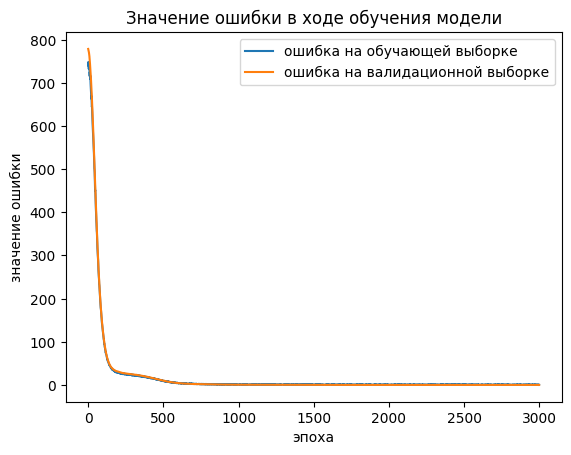

In [24]:
lstm_handler.plot_losses()

Построим также график изменения ошибки предсказания в километрах на валидационной выборке в ходе обучения:

(0.0, 27.95351951757474)

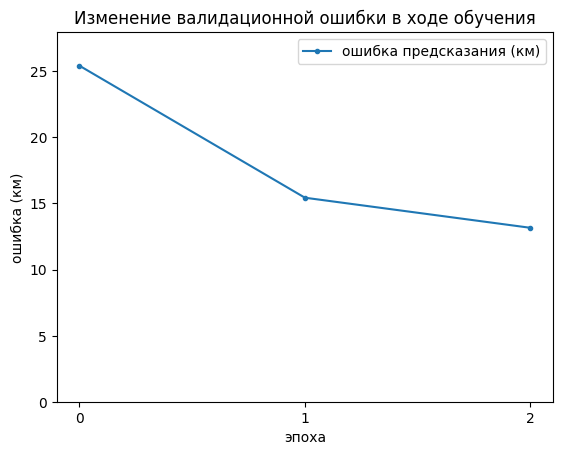

In [25]:
mean_hu_dists = np.mean(lstm_handler.distances, axis=(1, 2)) 
plt.title("Изменение валидационной ошибки в ходе обучения") 
plt.plot(mean_hu_dists, '.-', label="ошибка предсказания (км)")
plt.legend() 
plt.xlabel('эпоха') 
plt.ylabel('ошибка (км)')  
plt.xticks(range(len(mean_hu_dists)), range(len(mean_hu_dists)))  
plt.ylim(0, 1.1 * np.max(mean_hu_dists))

# Тестирование

Получим предскзания на тестовой выборке и оценим ошибку:

In [27]:
import math
actual3d, predicted3d, test_loss = lstm_handler.evaluate(test_loader, seq_dim)
base_pd = predicted3d 
base_loss = np.mean(test_loss)
base_loss = math.sqrt(base_loss)
base_loss

0.20771647202397497

Определим вспомогательную функцию построения карты и траектории на ней:

In [28]:
def map_hurricane(plt_title):  
    plt.figure(figsize=(20, 16))
    hm = Basemap(llcrnrlon=-100., llcrnrlat=0., 
                 urcrnrlon=20., urcrnrlat=60.,  
                 projection='lcc', lat_1=0., lat_2=20., lon_0=-60., 
                 resolution='l', area_thresh=1000.)
    hm.drawcoastlines()  
    hm.drawparallels(np.arange(-70, 70, 10), labels=[1, 1, 0, 0]) 
    hm.drawmeridians(np.arange(-110, 40, 10), labels=[0, 0, 0, 1])  
    plt.suptitle(plt_title, fontsize=64)  
    return hm  # возврат объекта нарисованной карты

In [79]:
def predict_next_points(points):
    predicted_points = []
    
    if (len(points) > 2):
        predicted_points.append([points[0, 0], points[0, 1]])
        predicted_points.append([points[1, 0], points[1, 1]])
    for i in range(len(points) - 2):
        start_point = (points[i, 0], points[i, 1])
        end_point = (points[i + 1, 0], points[i + 1, 1])
        dist = distance(start_point, end_point).km / 24
        direction = np.arctan2(points[i + 1, 1] - points[i, 1], points[i + 1, 0] - points[i, 0])
        next_point_lat = points[i + 1, 0] + (dist * np.cos(direction))
        next_point_lon = points[i + 1, 1] + (dist * np.sin(direction))
        predicted_points.append([next_point_lat, next_point_lon])

    return predicted_points

In [80]:
al_pd = []
for idx in range(len(test_x)):  
    id2 = test_ids[idx]  # извлечение ID ураган
    points = test_df.loc[test_df['ID'] == id2, ['Latitude', 'Longitude']].to_numpy()
    pr_ll = predict_next_points(points)
    al_pd.append(pr_ll)

Выведем фактическое и предскзаанное движение урагана:

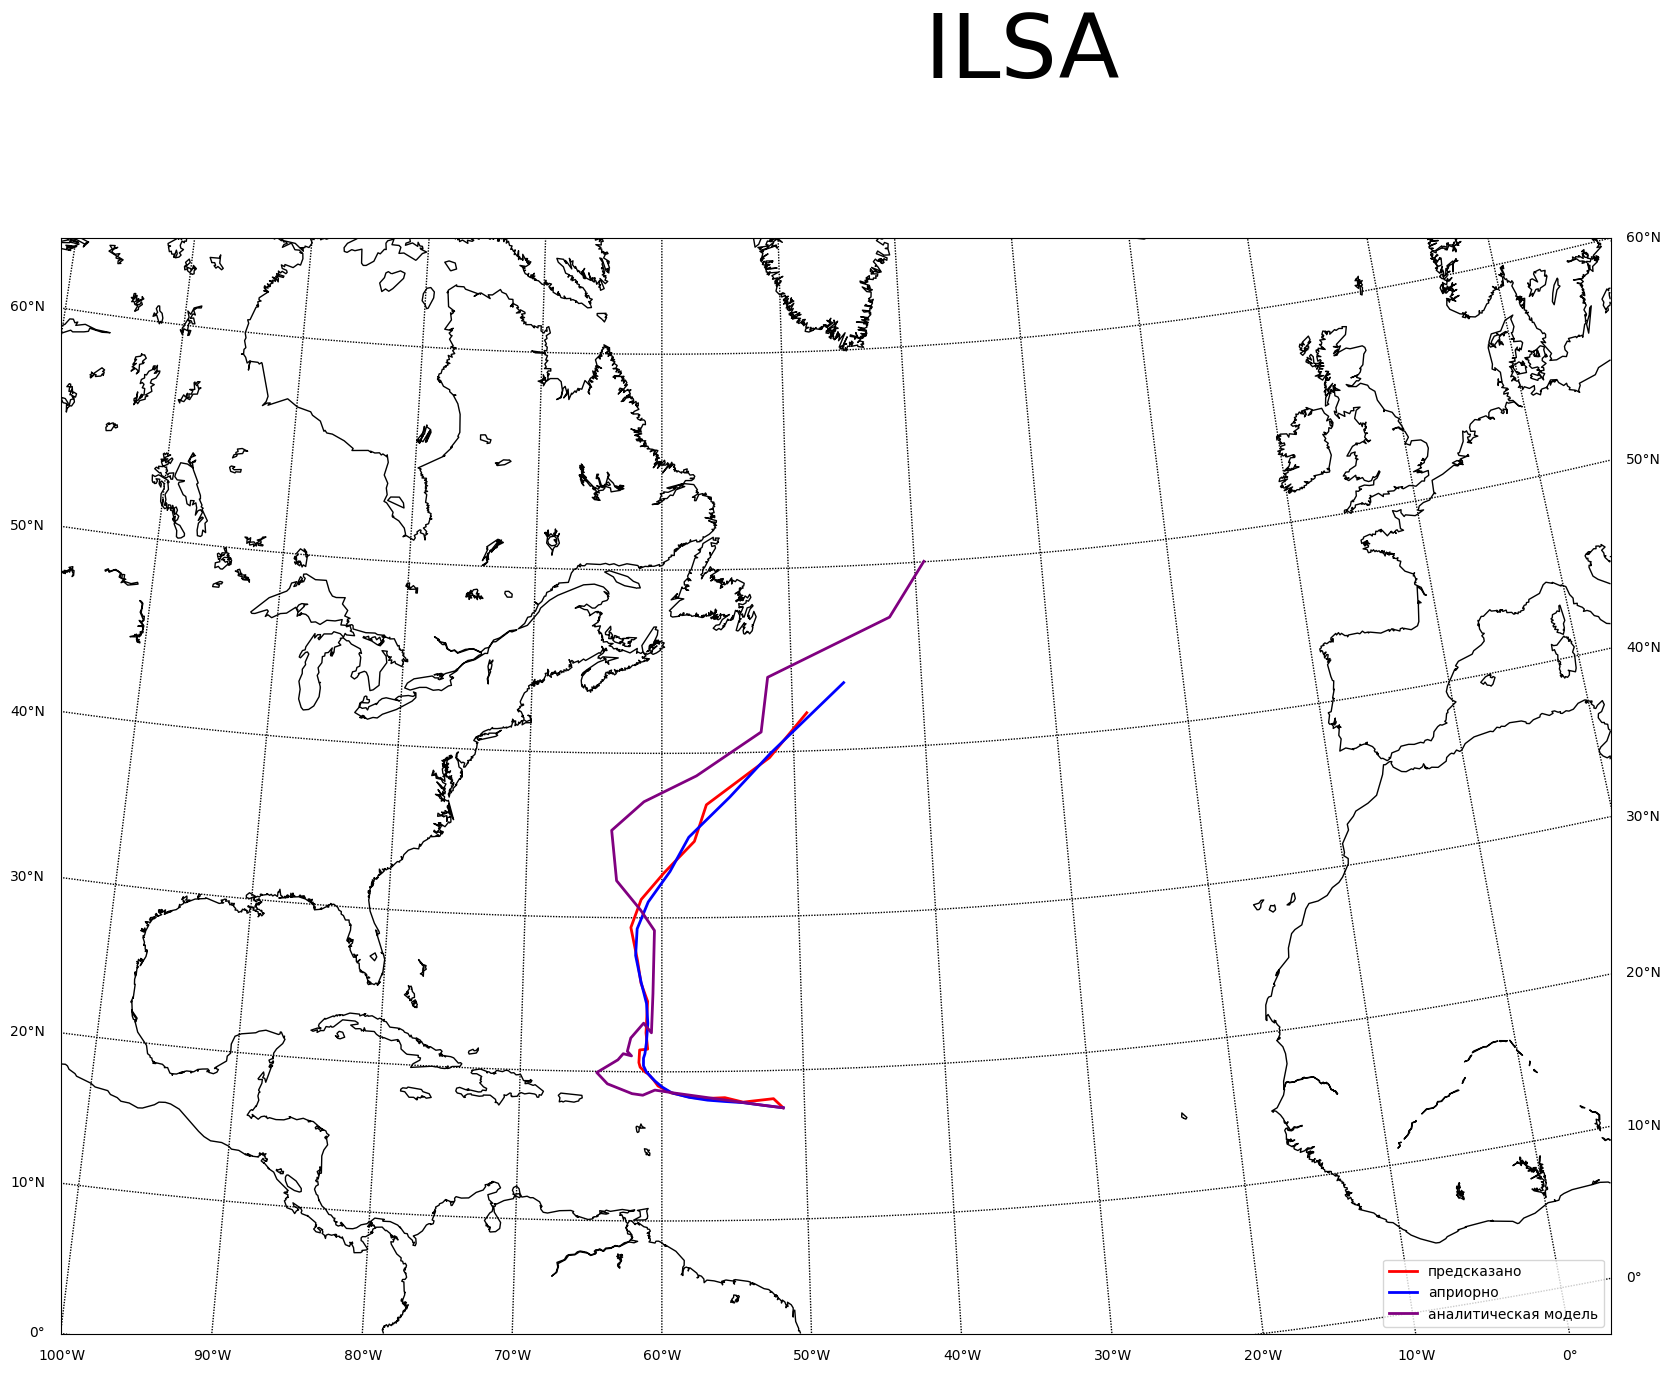

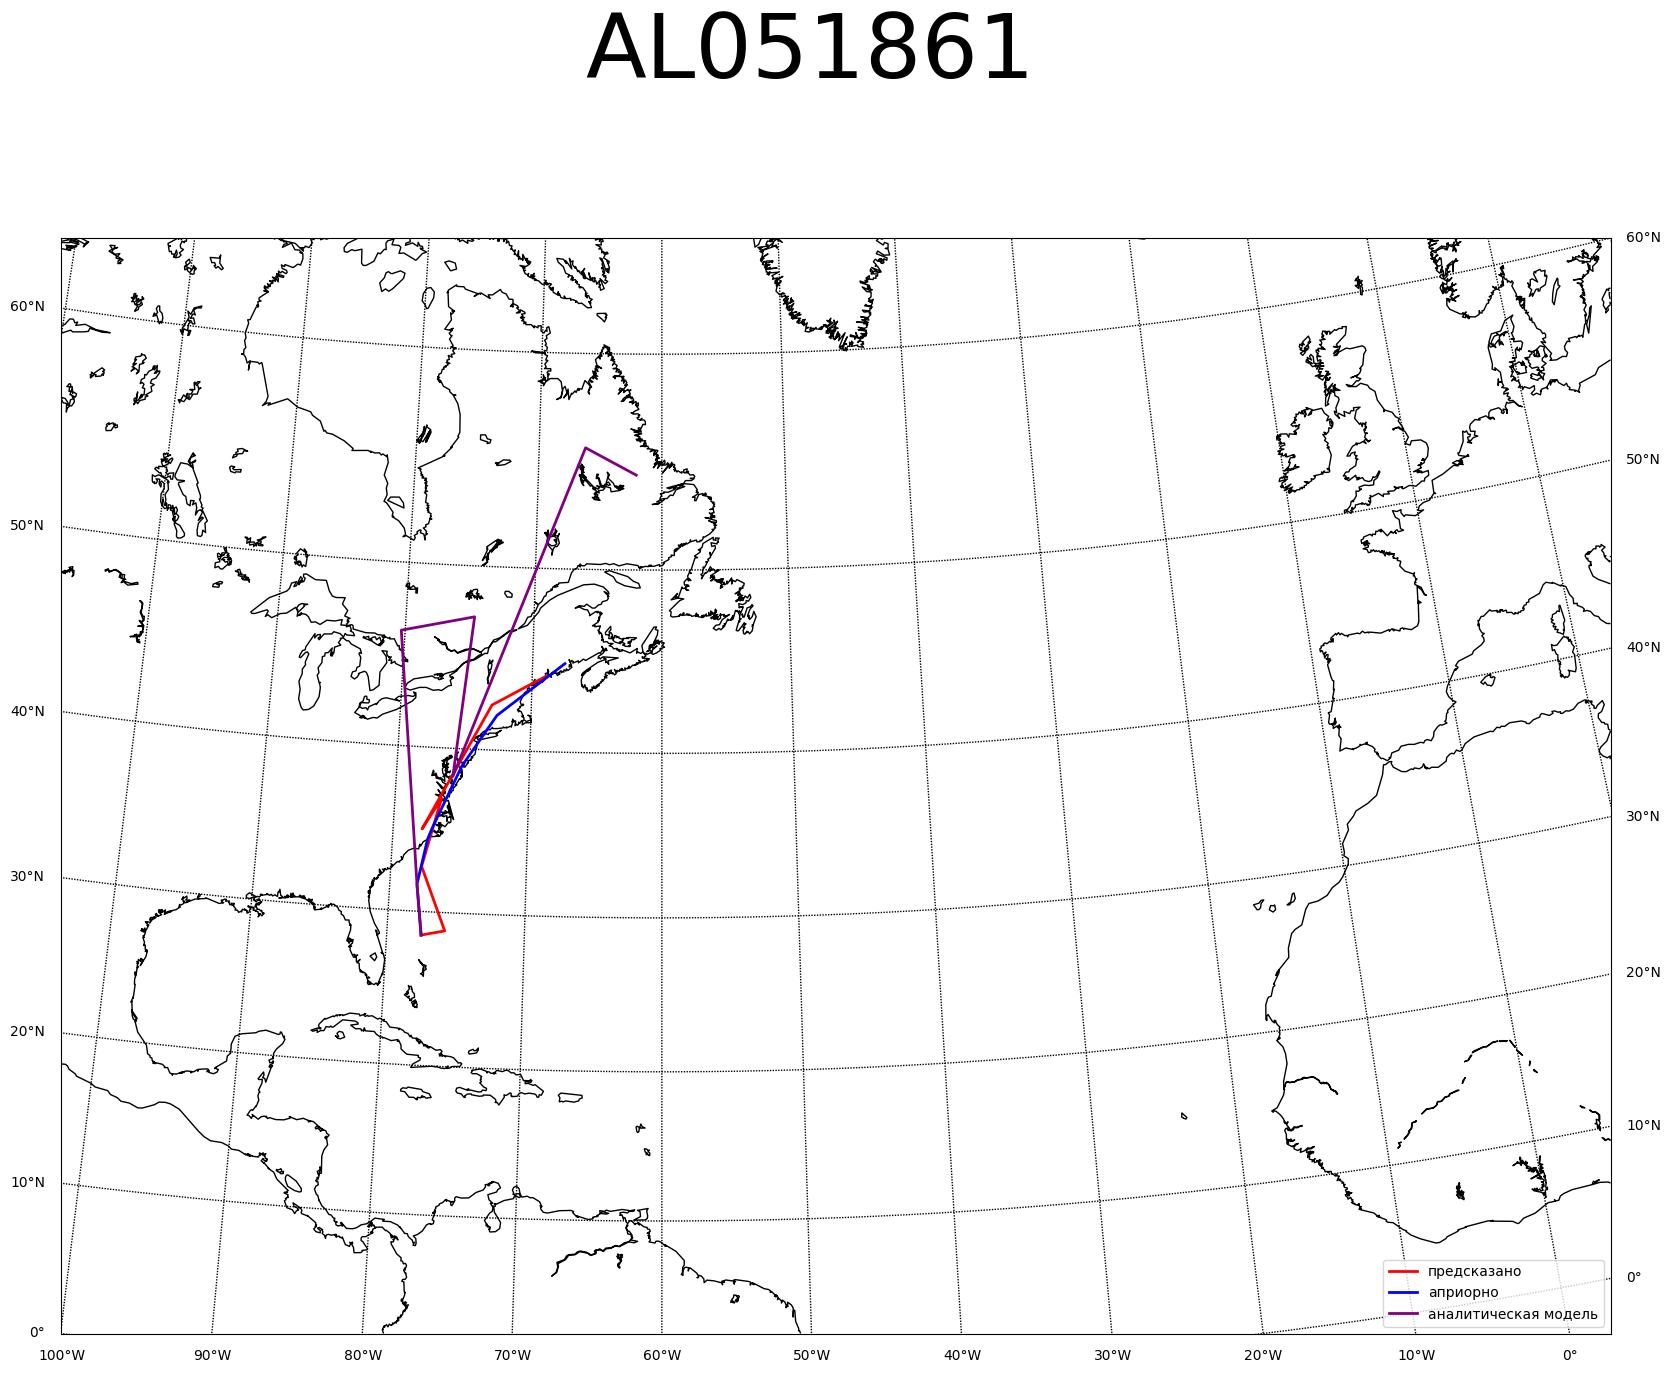

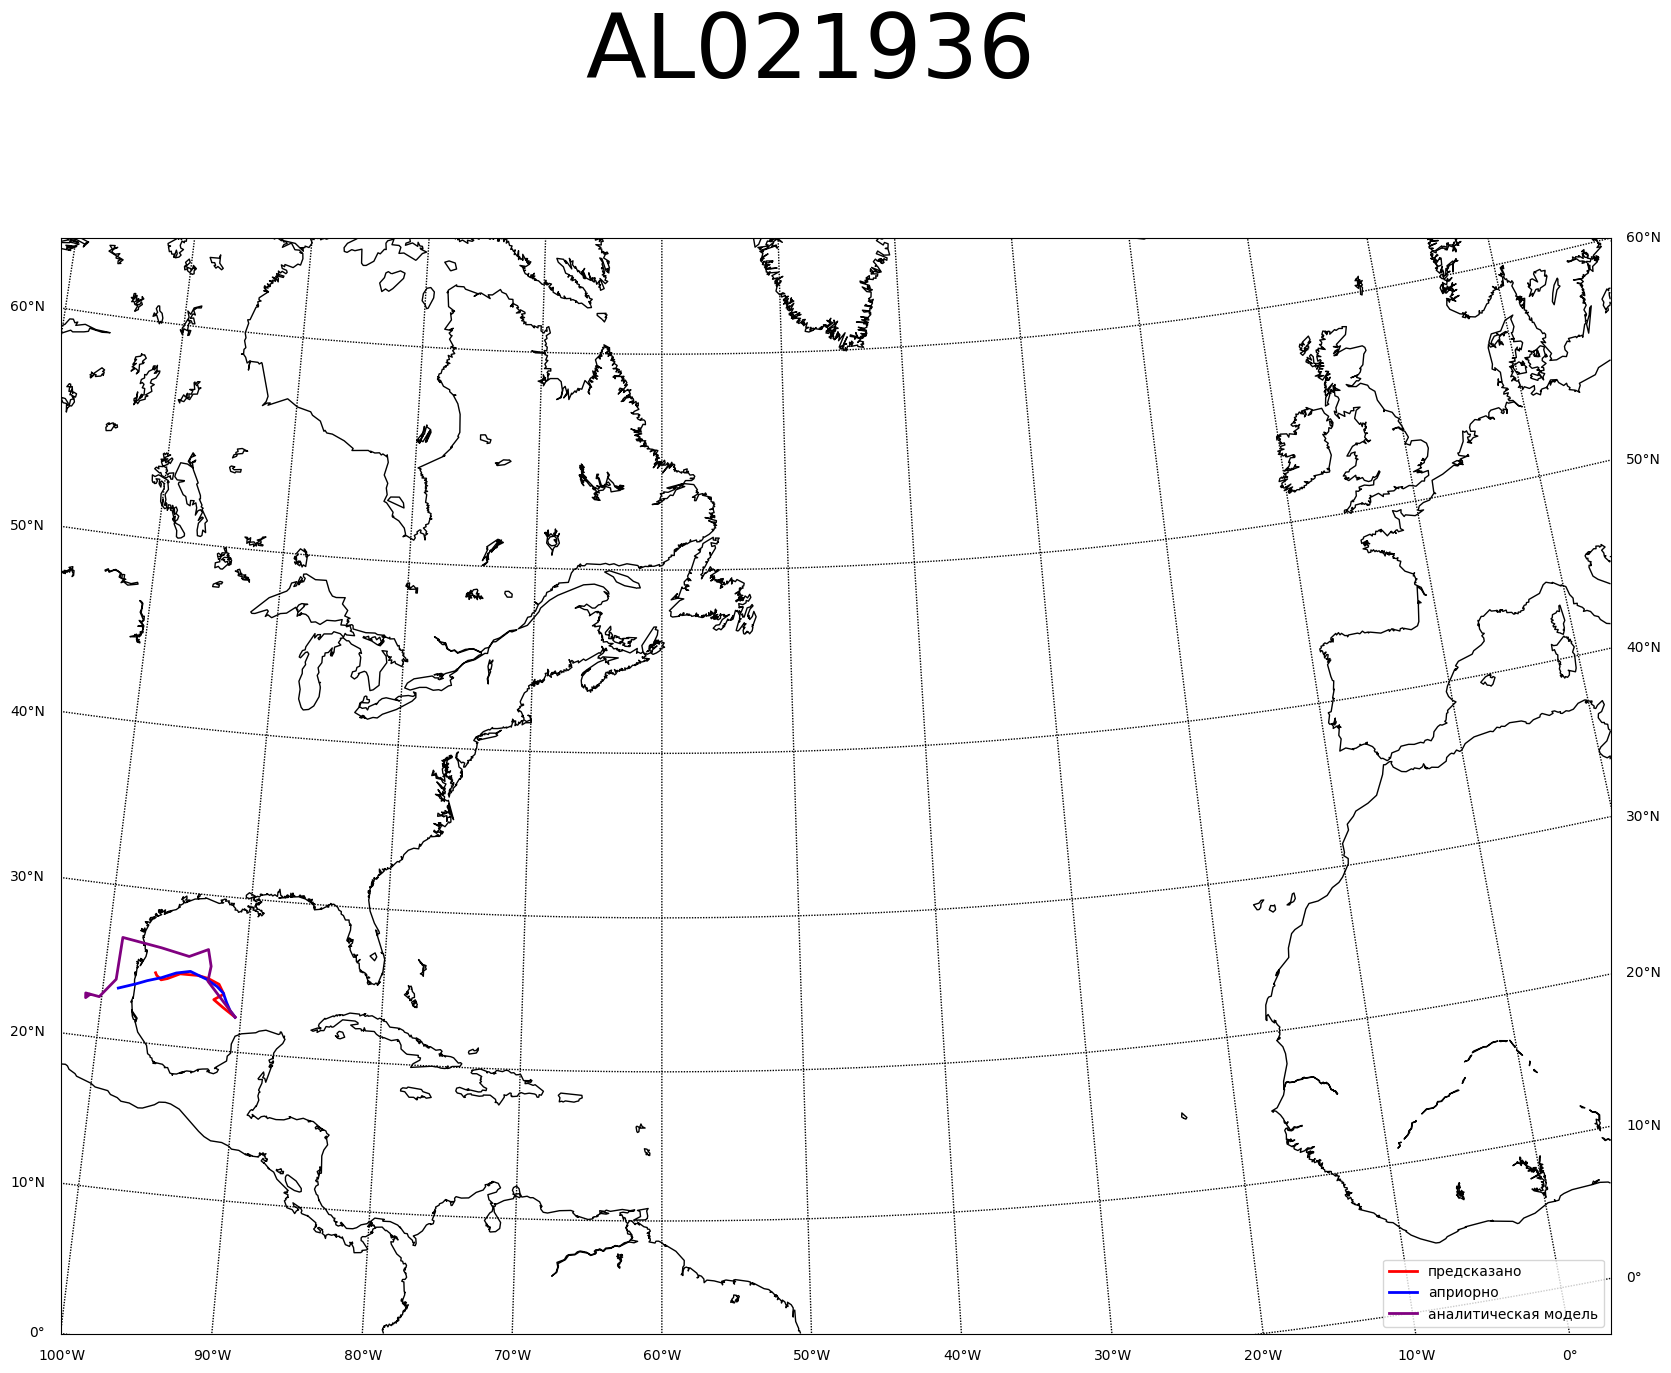

In [82]:
for idx in range(3):  # в цикле по первым 3 ураганам из тестовой выборки
    id2 = test_ids[idx]  
    storm_len = test_df.loc[test_df.ID == id2].shape[0] 
    origin = test_df.loc[test_df.ID == id2][['Latitude', 'Longitude']].iloc[0]  
    lat_pred = predicted3d[idx, :storm_len-1, 0]  
    lon_pred = predicted3d[idx, :storm_len-1, 1]  
    lat_actual = actual3d[idx, :storm_len-1, 0]  
    lon_actual = actual3d[idx, :storm_len-1, 1]

    lat_pred = np.insert(lat_pred, 0, origin[0])  
    lon_pred = np.insert(lon_pred, 0, origin[1])  
    lat_actual = np.insert(lat_actual, 0, origin[0]) 
    lon_actual = np.insert(lon_actual, 0, origin[1])  
    
    hu_name = test_df.loc[test_df.ID == id2, 'Name'].iloc[0] 
    if hu_name == "            UNNAMED":
        hu_name = test_df.loc[test_df.ID == id2, 'ID'].iloc[0]
    hurricane_map = map_hurricane(hu_name) 
    x1, y1 = hurricane_map(lon_pred, lat_pred) 
    x2, y2 = hurricane_map(lon_actual, lat_actual)
    
    base_line = al_pd[idx]
    base_line_lat = [item[0] for item in base_line]
    base_line_lon = [item[1] for item in base_line]
    x3, y3 = hurricane_map(base_line_lon, base_line_lat)
    
    plt.plot(x1, y1, '-', linewidth=2, color='red', label="предсказано") 
    plt.plot(x2, y2, '-', linewidth=2, color='blue', label="априорно")
    plt.plot(x3, y3, '-', linewidth=2, color='purple', label="аналитическая модель") 

    plt.legend(loc="lower right")
    plt.show()  

# Сравнение качества с другими моделями

## Несколько блоков LSTM с Dropout

In [32]:
class SeqLSTM(nn.Module): 
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, device): 
        super(SeqLSTM, self).__init__()  
        self.hidden_dim = hidden_dim  
        self.layer_dim = layer_dim  
        self.device = device  
        
        self.num_lstm = 4  
        dropout_rate = 0.1  
        self.fc_in = nn.Linear(input_dim, hidden_dim)  
        self.lstms = [nn.LSTM(hidden_dim, hidden_dim, layer_dim, batch_first=True).to(device)]
        self.lstms.extend([  
            nn.LSTM(hidden_dim, hidden_dim, layer_dim, batch_first=True).to(device)
            for _ in range(self.num_lstm - 1) 
        ])
        self.dropouts = [  
            nn.Dropout(dropout_rate).to(device)  
            for _ in range(self.num_lstm - 1) 
        ]
        self.fc = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):  
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device)  
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device)  
        
        out = self.fc_in(x)  
        for k in range(self.num_lstm - 1):  
            cur, (hn, cn) = self.lstms[k](out, (h0, c0))  
            out = out + self.dropouts[k](cur)  
        out, (hn, cn) = self.lstms[-1](out, (h0, c0)) 
        
        out = self.fc(out) 
        return out  

In [33]:
model = SeqLSTM(input_dim, 64, 1, output_dim, device)  
model.to(device)  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=120, verbose=True, factor=0.3)

In [34]:
lstm_handler = LSTM_Handler(model, mse_loss_func, optimizer, scheduler)  
lstm_handler.train(train_loader, val_loader, batch_size, 3000, eval_step=1000, clip_loss=10000.0) 

train loss=3.199099, val loss=2.809259: 100%|██████████████████████████████████████| 3000/3000 [04:23<00:00, 11.36it/s]


In [35]:
actual3d, predicted3d, test_loss = lstm_handler.evaluate(test_loader, seq_dim)
mul_pd = predicted3d 
mul_loss = math.sqrt(np.mean(test_loss))
mul_loss

1.5893437735006042

In [36]:
filename = 'mul_0.pkl'  
lstm_handler.save_model(filename) 

## Двунаправленный и однонаправленный блок LSTM

In [37]:
class BiLSTM(nn.Module):  
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, device): 
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim 
        self.layer_dim = layer_dim 
        self.device = device 
        
        self.bi_lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, 
                               batch_first=True, bidirectional=True)
        self.uni_lstm = nn.LSTM(2 * hidden_dim, hidden_dim, layer_dim,  
                                batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim) 
    
    def forward(self, x):
        h0 = torch.zeros(2 * self.layer_dim, x.size(0), self.hidden_dim).to(self.device) 
        c0 = torch.zeros(2 * self.layer_dim, x.size(0), self.hidden_dim).to(self.device)  
        out, (hn, cn) = self.bi_lstm(x, (h0, c0))  
        
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device)  
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device)  
        out, (hn, cn) = self.uni_lstm(out, (h0, c0))  
        
        out = self.fc(out)  
        return out 

In [38]:
model = BiLSTM(input_dim, hidden_dim, layer_dim, output_dim, device) 
model.to(device)  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)  
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=120, verbose=True, factor=0.3)

In [39]:
lstm_handler = LSTM_Handler(model, mse_loss_func, optimizer, scheduler) 
lstm_handler.train(train_loader, val_loader, batch_size, num_epochs, eval_step=1000, clip_loss=10000.0)

train loss=1.042781, val loss=0.441700: 100%|██████████████████████████████████████| 3000/3000 [03:16<00:00, 15.25it/s]


In [40]:
actual3d, predicted3d, test_loss = lstm_handler.evaluate(test_loader, seq_dim) 
bi_pd = predicted3d 
bi_loss = math.sqrt(np.mean(test_loss))
bi_loss


0.6432105847661365

In [41]:
filename = 'bi_0.pkl'  
lstm_handler.save_model(filename) 

## Модель с блоком GRU

In [42]:
class GRUmodel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, device): 
        super(GRUmodel, self).__init__()  
        self.hidden_dim = hidden_dim  
        self.layer_dim = layer_dim 
        self.device = device 
        
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, 
                          batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim) 
    
    def forward(self, x): 
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device) 
        out, hn = self.gru(x, h0) 
        
        out = self.fc(out)  
        return out 

In [43]:
model = GRUmodel(input_dim, hidden_dim, layer_dim, output_dim, device)
model.to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=120, verbose=True, factor=0.3)

In [44]:
lstm_handler = LSTM_Handler(model, mse_loss_func, optimizer, scheduler) 
lstm_handler.train(train_loader, val_loader, batch_size, num_epochs, eval_step=1000, clip_loss=10000.0)  

train loss=1.609932, val loss=0.278591: 100%|██████████████████████████████████████| 3000/3000 [02:16<00:00, 21.90it/s]


In [45]:
actual3d, predicted3d, test_loss = lstm_handler.evaluate(test_loader, seq_dim)
gru_pd = predicted3d  
gru_loss = math.sqrt(np.mean(test_loss))
gru_loss

0.4074665425251721

In [46]:
filename = 'gru_0.pkl'  
lstm_handler.save_model(filename)

# Регрессия с градиентным бустингом

In [47]:
gb_x = train_x.reshape((-1, train_x.shape[-1]))  # преобразованные обучающие данные для градиентного бустинг / вход
gb_y = train_y.reshape((-1, train_y.shape[-1]))  # и выход
model_lat = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0, loss='squared_error'
                                      ).fit(gb_x, gb_y[:, 0])  
model_lon = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0, loss='squared_error'
                                      ).fit(gb_x, gb_y[:, 1])  

gb_test_x = test_x.reshape((-1, test_x.shape[-1]))  
pd_lat = model_lat.predict(gb_test_x)  
pd_lon = model_lon.predict(gb_test_x)  
gb_pd = np.stack((pd_lat[:, None], pd_lon[:, None]), axis=1) 
gb_pd = gb_pd.reshape(test_y.shape)  
# diff = np.linalg.norm(gb_pd - test_y, axis=2) 
# gb_loss = math.sqrt(np.mean(diff))
# gb_loss

# Визуальное сравнение предсказаний

Построим визуализации предсказаний моедлей для 3 ураганов:

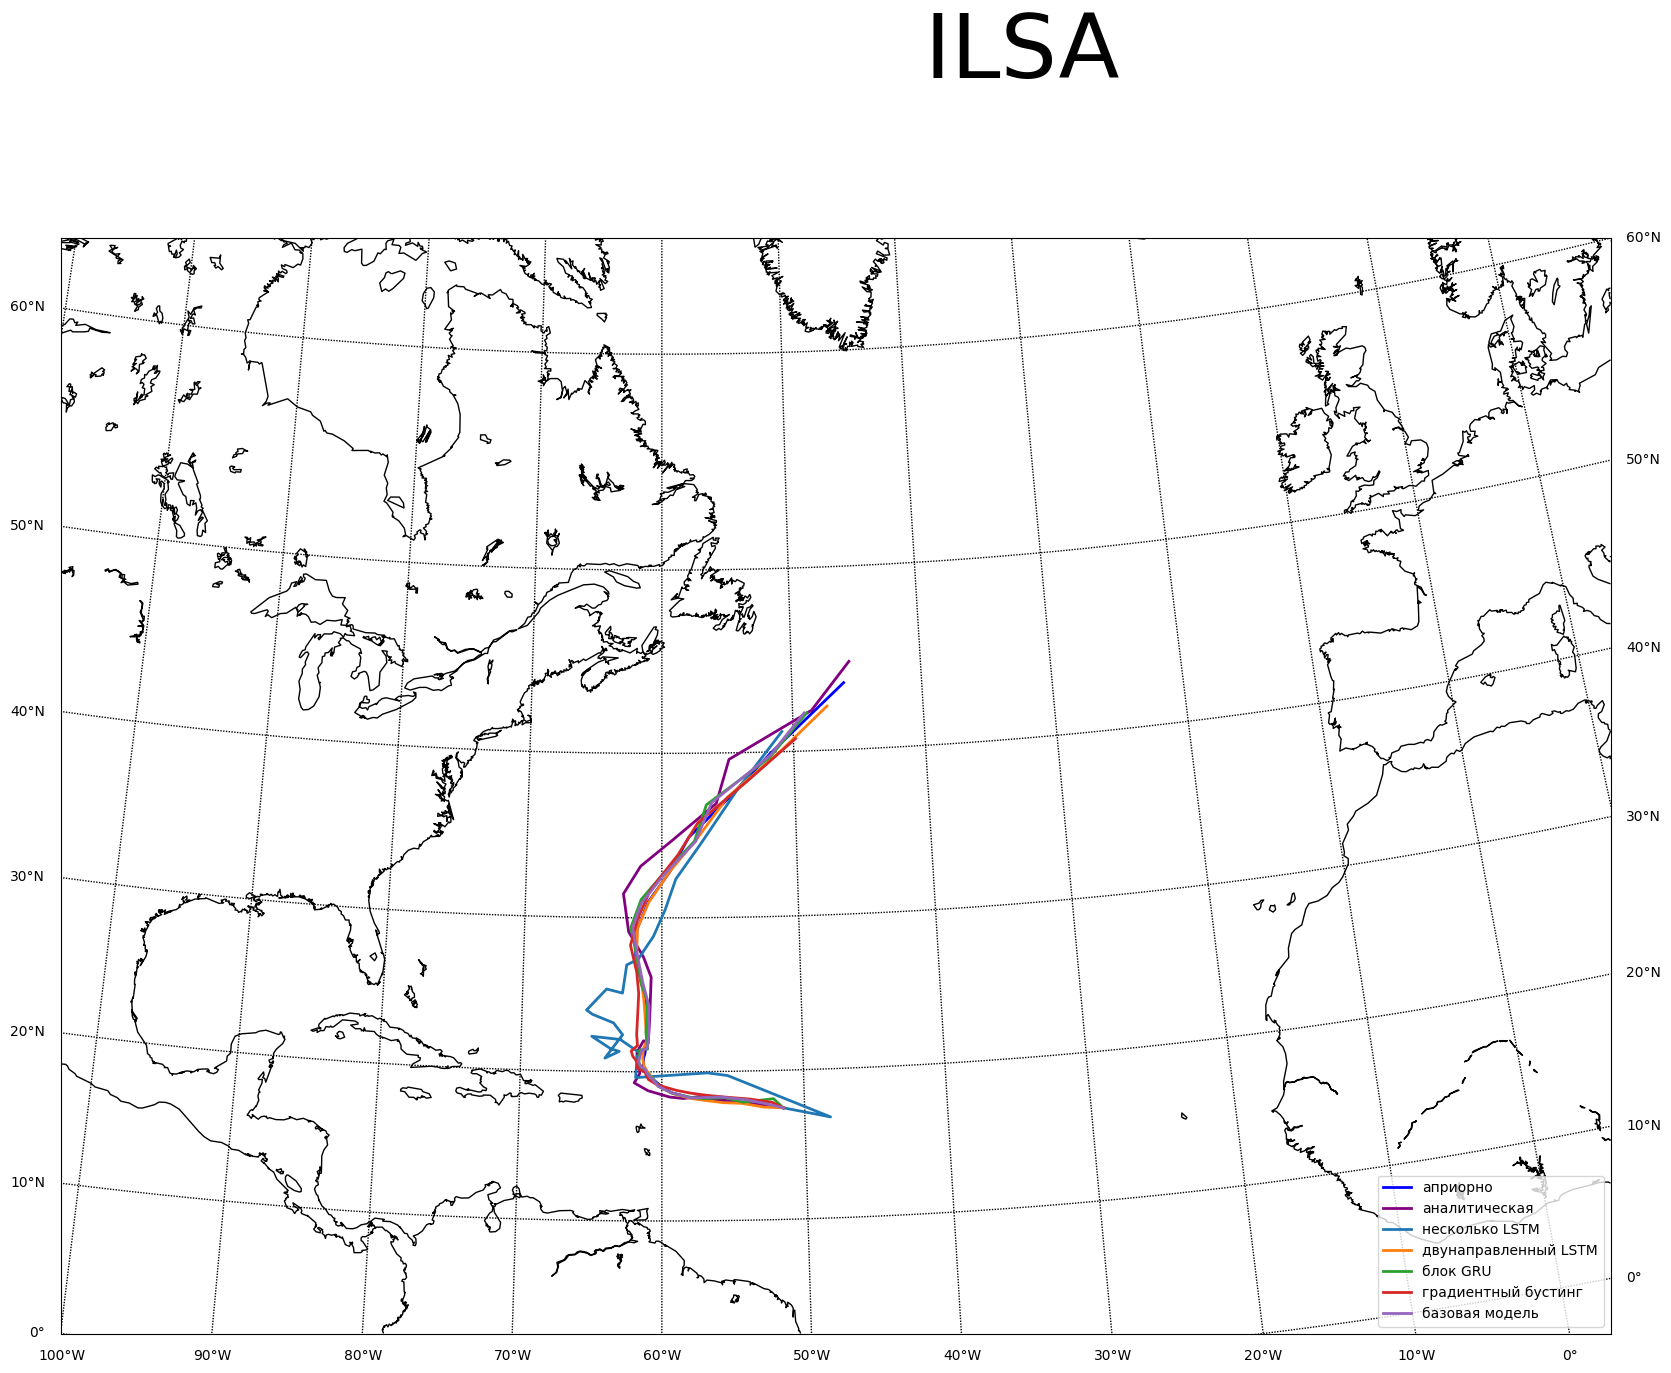

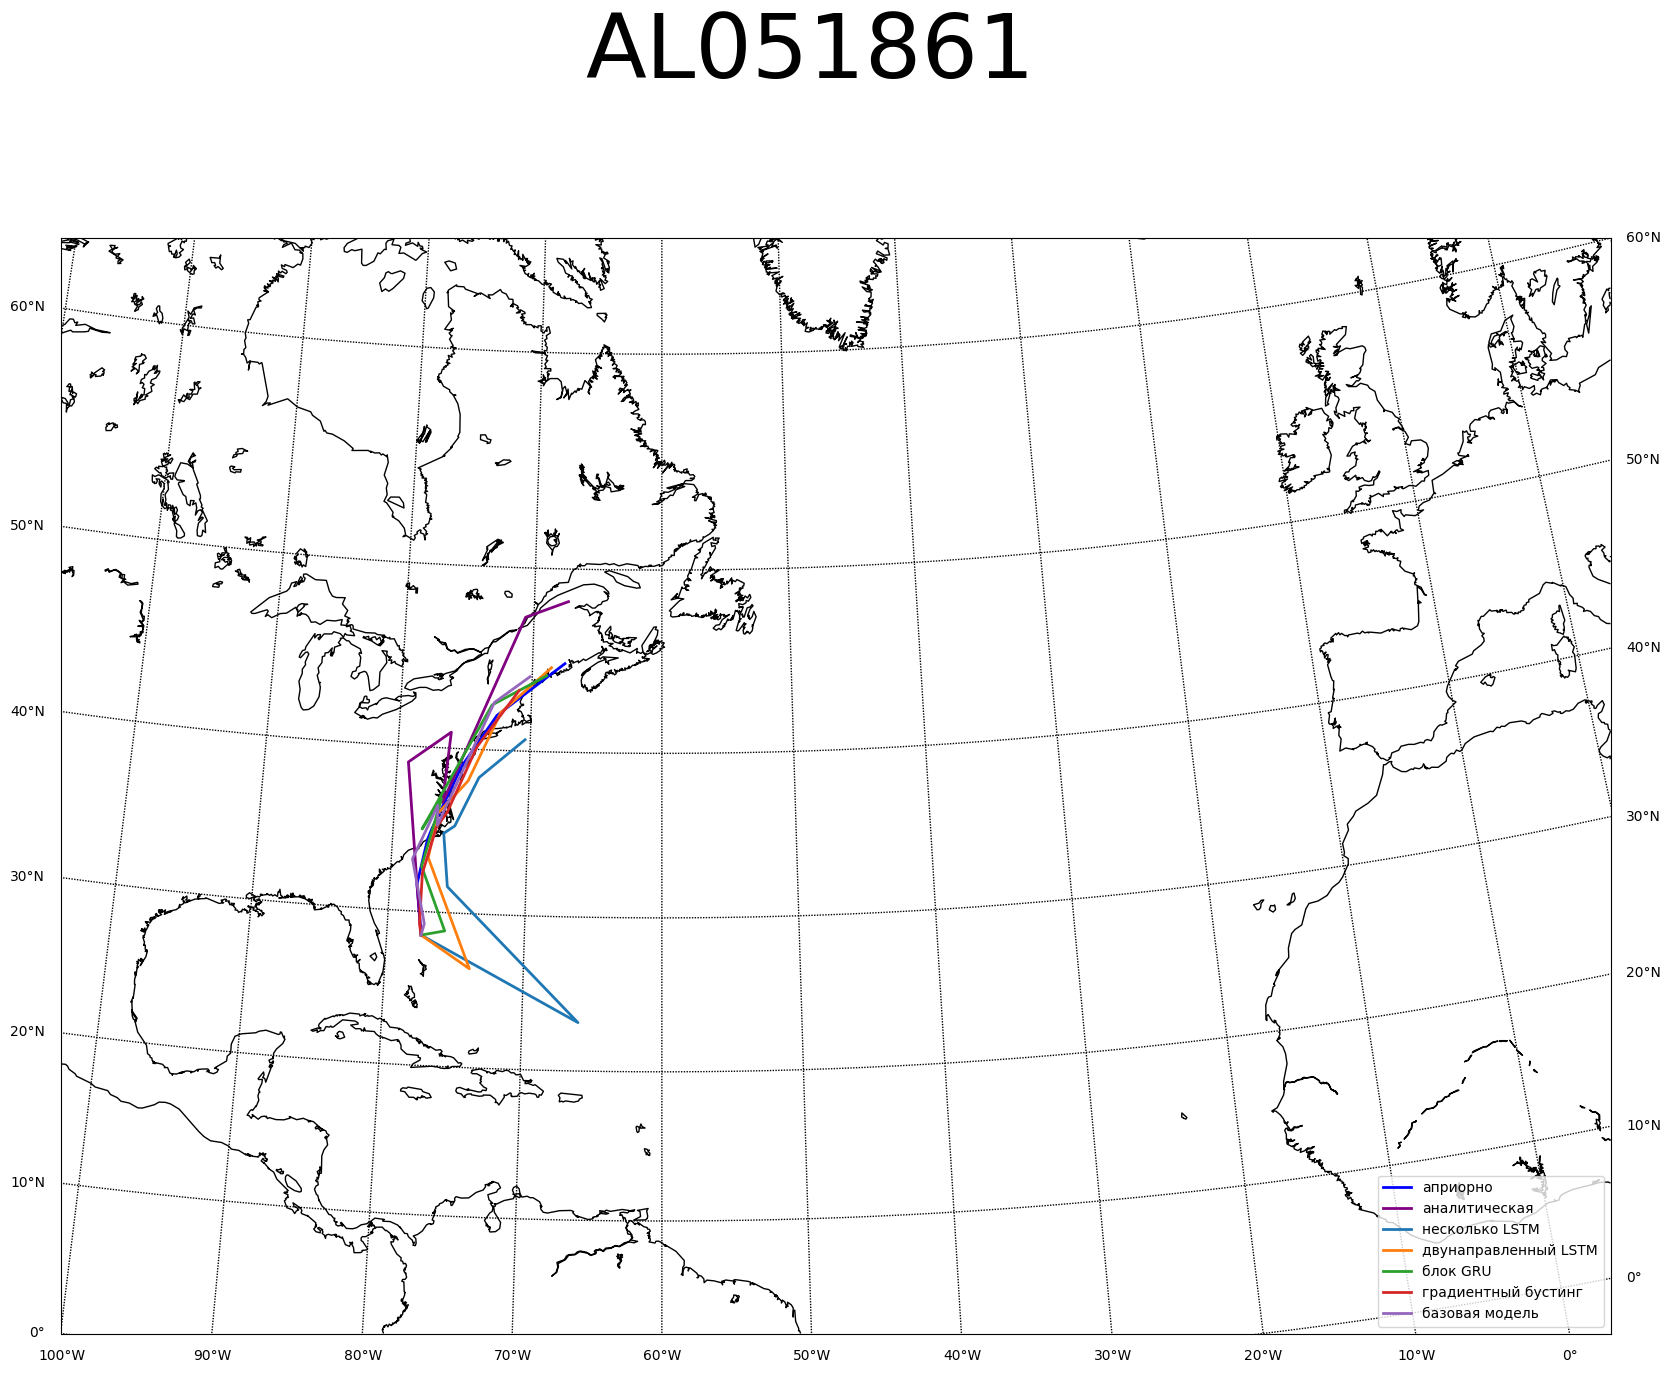

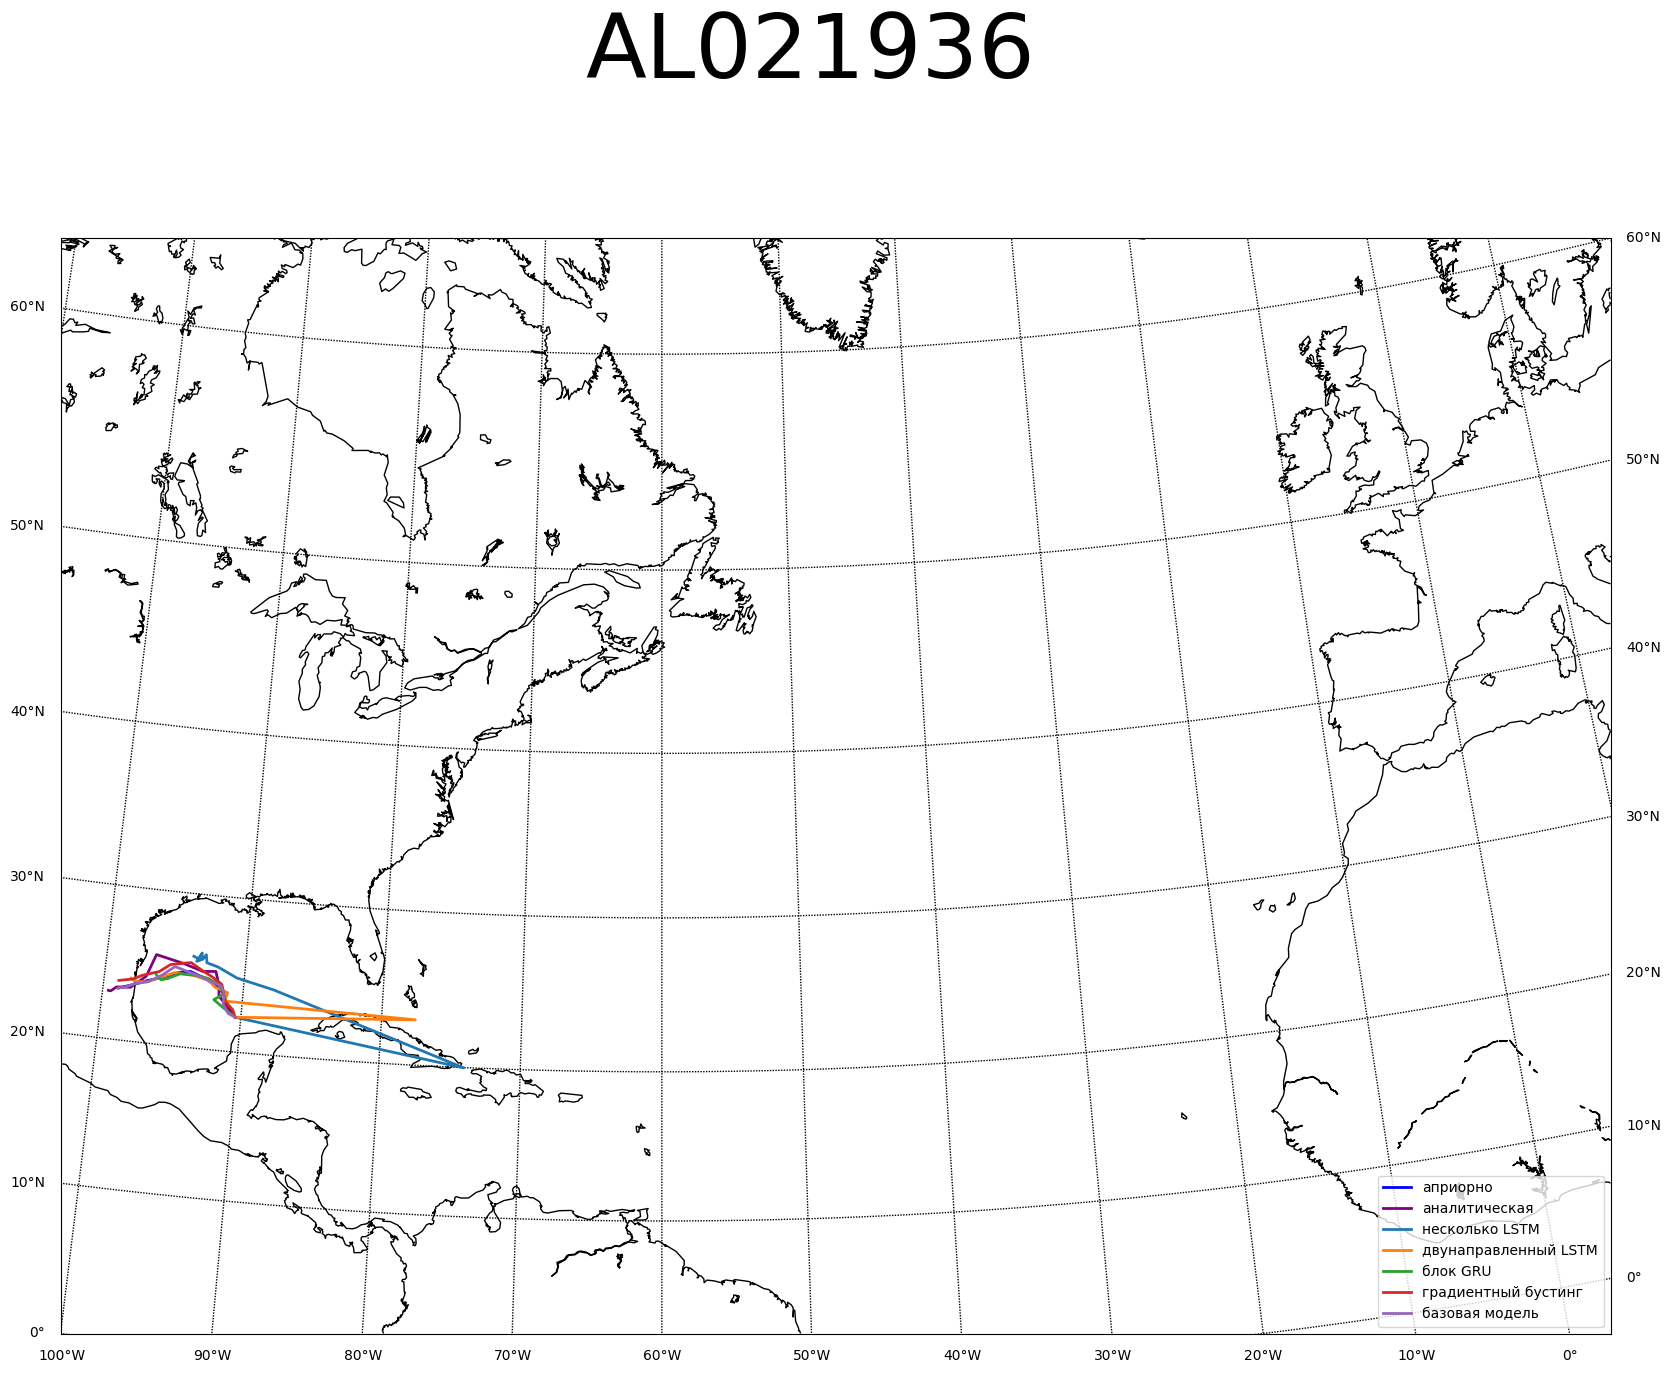

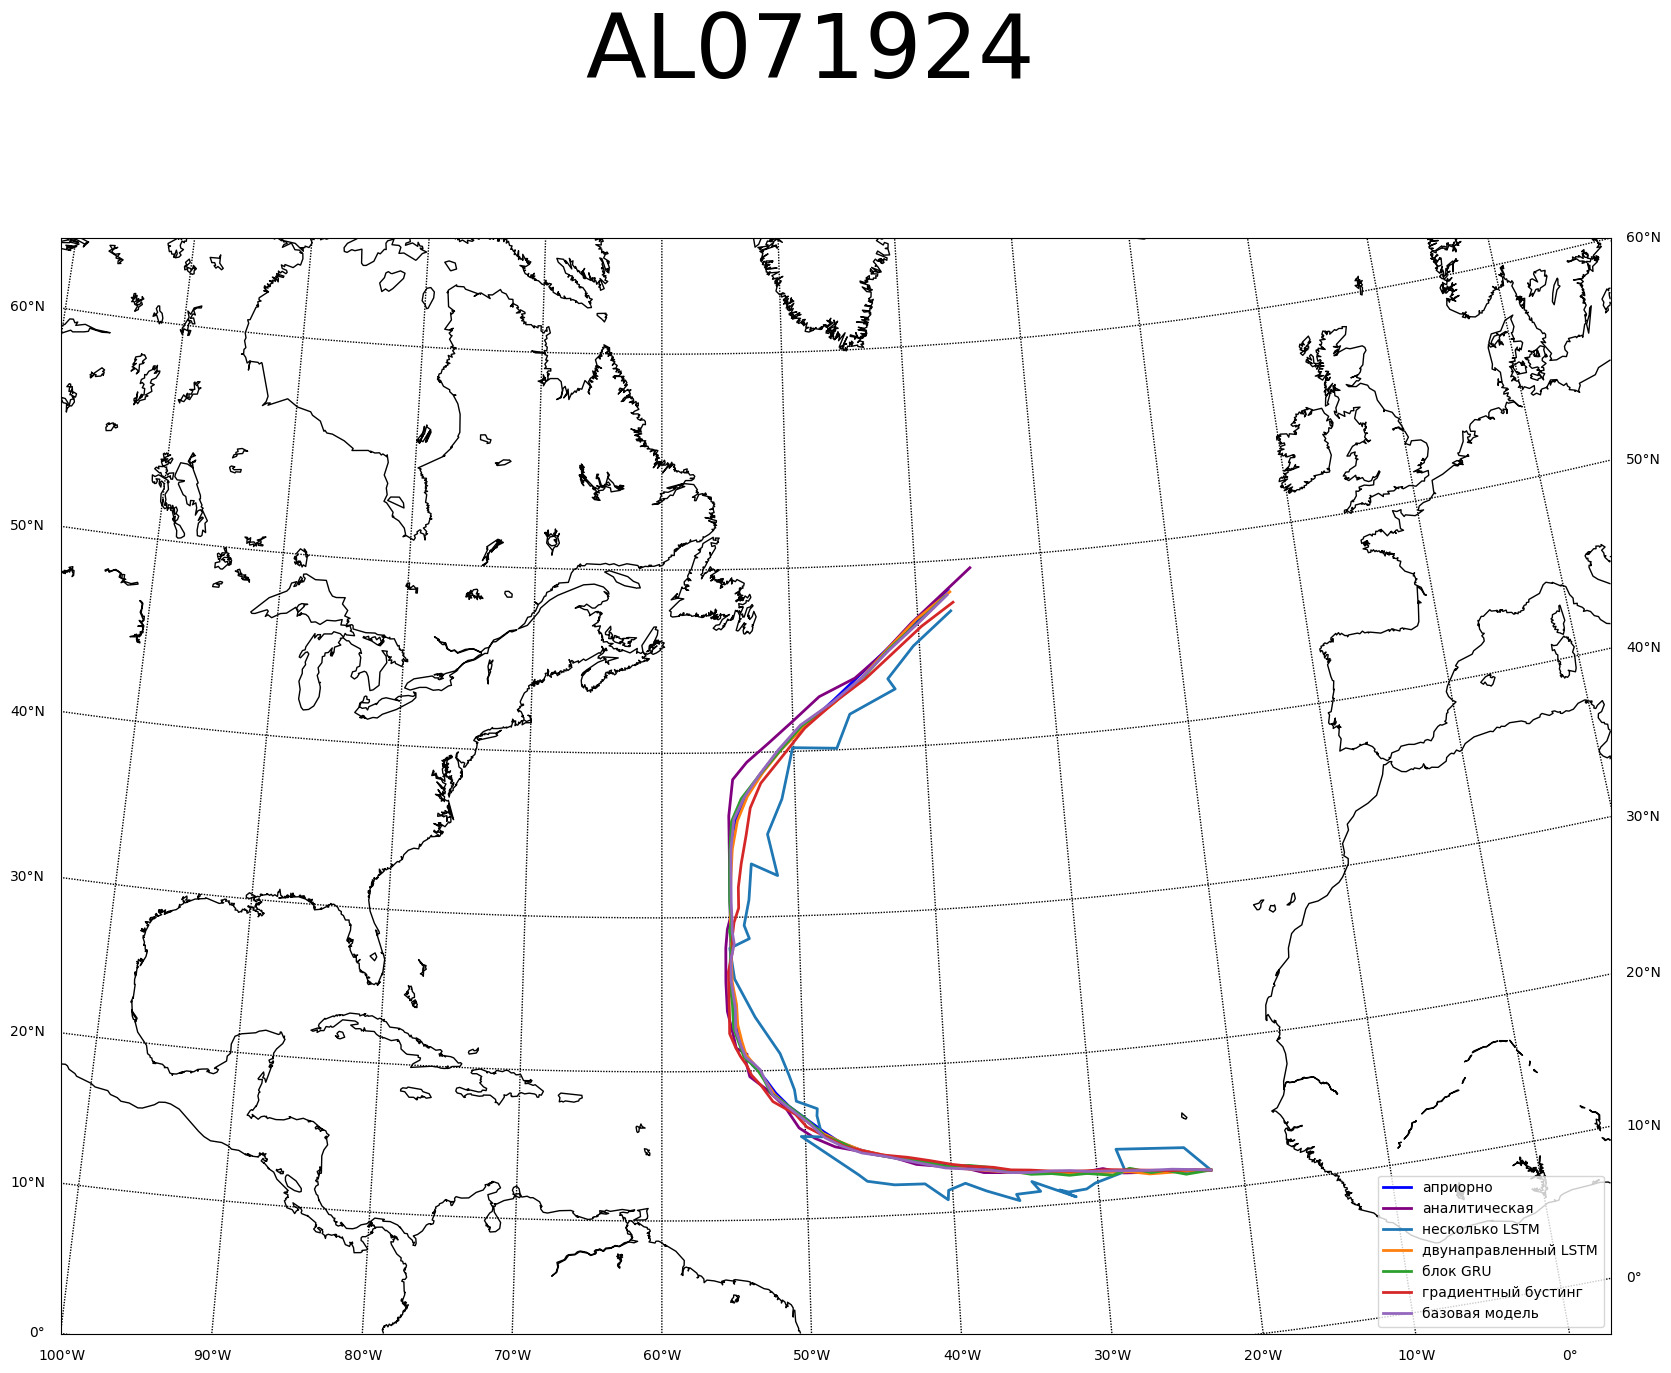

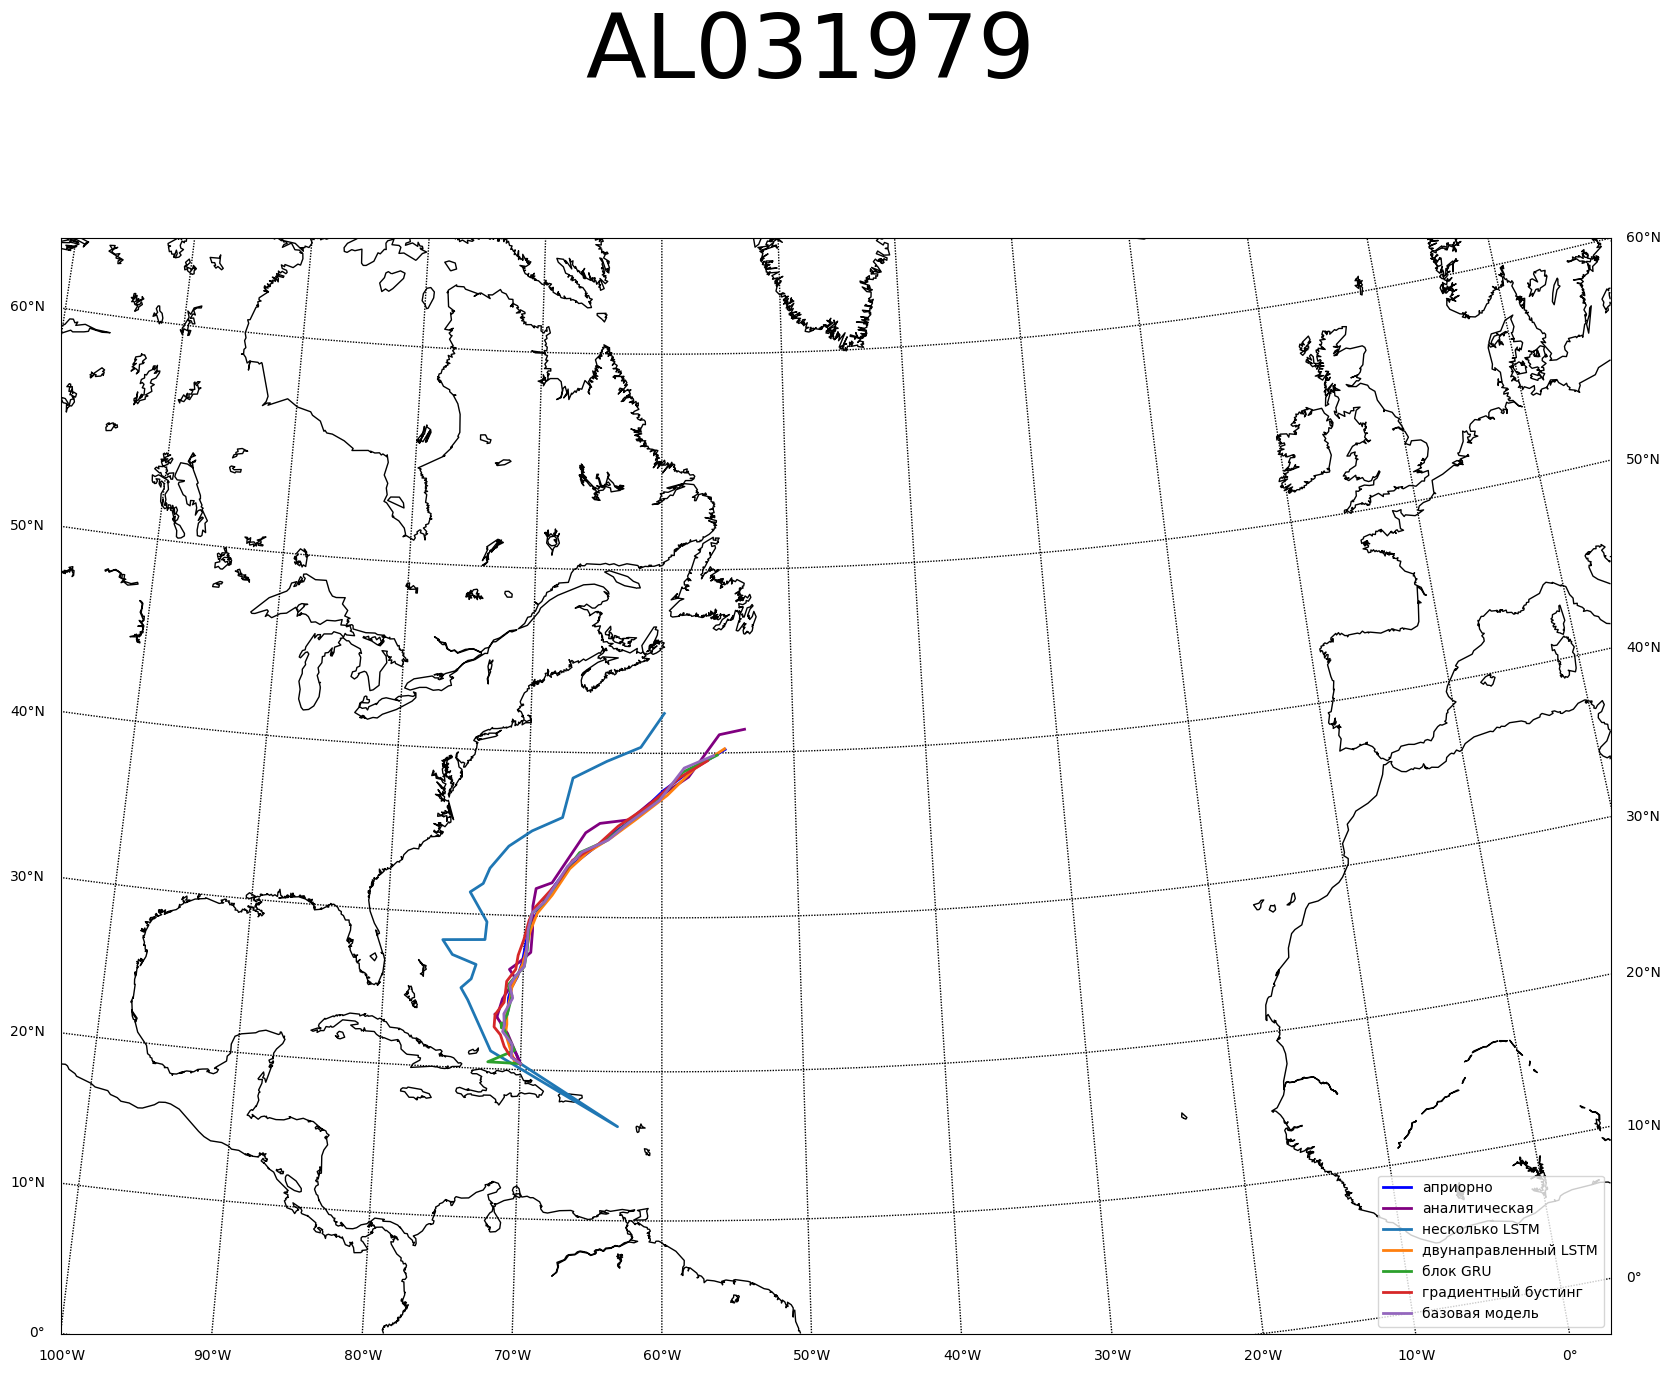

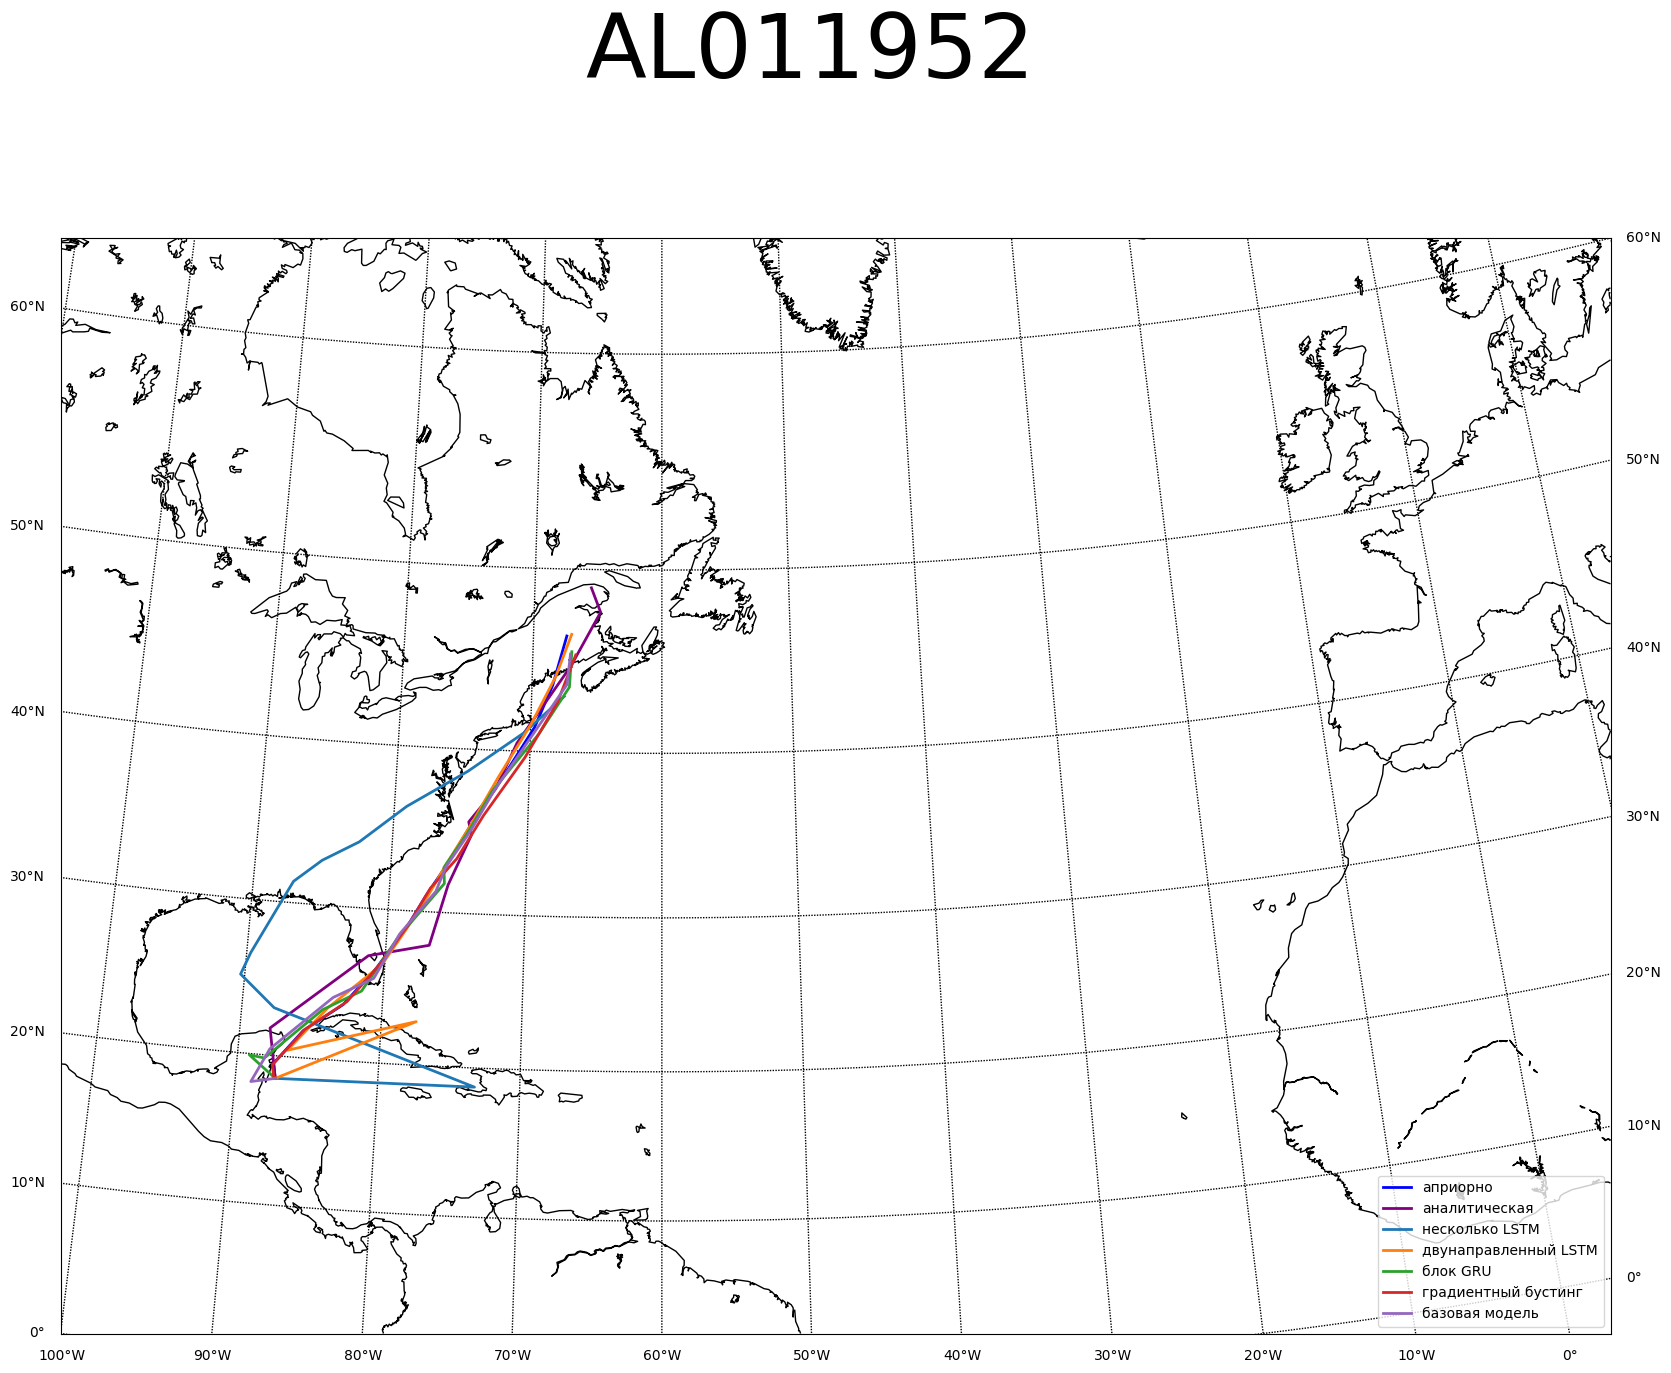

In [71]:
for idx in range(6):  
    id2 = test_ids[idx] 
    storm_len = test_df.loc[test_df.ID == id2].shape[0] 
    origin = test_df.loc[test_df.ID == id2][['Latitude', 'Longitude']].iloc[0]  
    lat_actual = actual3d[idx, :storm_len-1, 0]  
    lon_actual = actual3d[idx, :storm_len-1, 1]  
    lat_actual = np.insert(lat_actual, 0, origin[0])  
    lon_actual = np.insert(lon_actual, 0, origin[1])  
    
    hu_name = test_df.loc[test_df.ID == id2, 'Name'].iloc[0]  
    if hu_name == "            UNNAMED":
        hu_name = test_df.loc[test_df.ID == id2, 'ID'].iloc[0]
    hurricane_map = map_hurricane(hu_name)  
    x1, y1 = hurricane_map(lon_actual, lat_actual) 
    plt.plot(x1, y1, '-', linewidth=2, color='blue', label="априорно") 
    
    base_line = al_pd[idx]
    base_line_lat = [item[0] for item in base_line]
    base_line_lon = [item[1] for item in base_line]
    x3, y3 = hurricane_map(base_line_lon, base_line_lat)
    plt.plot(x3, y3, '-', linewidth=2, color='purple', label="аналитическая")  

    for pd_set, pd_name in zip((mul_pd, bi_pd, gru_pd, gb_pd, base_pd), ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель')):
        lat_pred = pd_set[idx, :storm_len-1, 0]  
        lon_pred = pd_set[idx, :storm_len-1, 1]  
        lat_pred = np.insert(lat_pred, 0, origin[0])  
        lon_pred = np.insert(lon_pred, 0, origin[1])  
        x2, y2 = hurricane_map(lon_pred, lat_pred) 
        plt.plot(x2, y2, '-', linewidth=2, label=pd_name) 
        
    
    
    plt.legend(loc="lower right")  # вывод поля-легенды карты
    plt.show()  # вывод карты

In [49]:
def calc_pred_dist(gt_pts, pd_pts):  # расчёт ошибки в километрах по выборке
    all_errors = []  
    for gt_batch, pd_batch in zip(gt_pts, pd_pts):  
        all_errors.append([  
                distance(lonlat(gt_lon, gt_lat),
                         lonlat(pd_lon, pd_lat)).km  
                for (gt_lat, gt_lon), (pd_lat, pd_lon) in zip(  
                     gt_batch, pd_batch  #
                )
            ])
    return all_errors 

In [51]:
num_comp = 10  # количество выводимых ураганов
comp_data = [  
    [model_name, *np.mean(calc_pred_dist(actual3d, pd_pts), axis=1)[:num_comp]]  
    for model_name, pd_pts in zip(  
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель', 'аналитическая модель'), 
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd)  
    )
]
comp_columns = ['модель'] + [
    test_df.loc[test_df.ID == test_id, 'Name'].iloc[0]  
    for test_id in test_ids[:10]   
]  
comp_df = pd.DataFrame(comp_data, columns=comp_columns) 
comp_df  # 

модель                 ILSA              UNNAMED  \
0        несколько LSTM           121.599718            82.661965   
1  двунаправленный LSTM             7.091574            13.007557   
2              блок GRU            17.611461            18.758892   
3   градиентный бустинг            27.985765            14.711425   
4        базовая модель            16.101198            17.477247   

               UNNAMED              UNNAMED              UNNAMED  \
0           105.699187           163.684059           127.578874   
1            18.740867             6.209986             4.497068   
2            15.137706            12.508297            14.268573   
3             7.973305            25.620100            17.963023   
4             3.633591            11.403678             9.423786   

               UNNAMED              UNNAMED              UNNAMED  \
0           135.064279           177.233847            79.027068   
1            17.682756             9.728449             8.453210   
2            18.583759            20.822499             7.973596   
3            28.324391            34.413080             7.705419   
4            13.587875            19.427159             6.666704   

               UNNAMED              UNNAMED  
0           111.122010           117.505824  
1            11.910514             8.997177  
2            24.802819            14.628597  
3            27.671548            38.319209  
4            20.396878            14.164617

Теперь рассчитаем ошибку определения координат точек урагана для нескольких примеров (в гардусах по каждой географической координате и в км):

In [52]:
num_pts = 5  # количество точек урагана для сравнения
k = 0  
test_id, single_hu = test_ids[k], actual3d[k]  
comp_data = [  
    [model_name, *(pd_pts[k] - single_hu)[:num_pts]]  
    for model_name, pd_pts in zip(  
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель'),  
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd) 
    )
]
hu_name = test_df.loc[test_df.ID == test_id, 'Name'].iloc[0]  
comp_columns = [hu_name] + [ 
    ('{}/широта'.format(k), '{}/долгота'.format(k)) 
    for k in range(num_pts)  
]  
comp_df = pd.DataFrame(comp_data, columns=comp_columns) 
comp_df  

ILSA                      (0/широта, 0/долгота)  \
0        несколько LSTM                    [-0.90667343, 4.694313]   
1  двунаправленный LSTM                 [-0.12026024, 0.032844543]   
2              блок GRU                   [0.42419815, 0.73827744]   
3   градиентный бустинг  [0.17605704228157748, 0.6567992017076918]   
4        базовая модель                   [0.09747505, 0.19963455]   

                      (1/широта, 1/долгота)  \
0                   [1.8192158, -1.0526695]   
1               [-0.044986725, -0.07109451]   
2                [0.03596306, 0.0011787415]   
3  [0.22855915494237777, 0.510516183600501]   
4                   [0.18379974, 0.2551651]   

                        (2/широта, 2/долгота)  \
0                     [1.9132175, -1.1754646]   
1                 [-0.07970238, -0.085308075]   
2                   [0.25267982, 0.024093628]   
3  [0.27644044804922885, 0.21657221647043912]   
4                     [0.2983837, -0.2594757]   

                         (3/широта, 3/долгота)  \
0                       [1.5115337, -5.050106]   
1                  [-0.03981781, 0.0088272095]   
2                     [0.10683441, -0.2298088]   
3  [0.3193809219998194, -0.017720298434632298]   
4                   [0.18337631, -0.010719299]   

                       (4/широта, 4/долгота)  
0                     [2.730074, -3.6485443]  
1                  [-0.07230377, 0.10630417]  
2                 [-0.015382767, 0.18535233]  
3  [0.27643827000588317, 0.1255832378705648]  
4                  [-0.04696083, 0.14299393]

In [53]:
k = 5  
test_id, single_hu = test_ids[k], actual3d[k]  
comp_data = [  
    [model_name, *calc_pred_dist([single_hu], [pd_pts[k]])[0][:num_pts]] 
    for model_name, pd_pts in zip( 
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель'), 
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd) 
    )
]
hu_name = test_df.loc[test_df.ID == test_id, 'Name'].iloc[0]  
comp_columns = [hu_name] + [  
    '{}/км'.format(k)  
    for k in range(num_pts)  
]  
comp_df = pd.DataFrame(comp_data, columns=comp_columns)
comp_df  # ... и вывод таблицы на экран

UNNAMED         0/км        1/км        2/км        3/км  \
0        несколько LSTM  1498.004196  270.503102  777.024910  909.854453   
1  двунаправленный LSTM  1091.643876  184.594439  115.728575   53.087649   
2              блок GRU   189.910873  348.906326  153.623608  195.005841   
3   градиентный бустинг   112.105092  338.294861  332.615887  320.098039   
4        базовая модель   216.805070  279.326735   89.191978   74.247597   

         4/км  
0  921.417349  
1   13.347463  
2   92.105803  
3  311.907875  
4   63.215092

In [54]:
k = 5 
test_id, single_hu = test_ids[k], actual3d[k]  
comp_data = [  
    [model_name, *(pd_pts[k] - single_hu)[:num_pts]]  
    for model_name, pd_pts in zip(  
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель'), 
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd)  
    )
]
hu_name = test_df.loc[test_df.ID == test_id, 'Name'].iloc[0] 
comp_columns = [hu_name] + [  
    ('{}/широта'.format(k), '{}/долгота'.format(k)) 
    for k in range(num_pts)  
] 
comp_df = pd.DataFrame(comp_data, columns=comp_columns)
comp_df  

UNNAMED                      (0/широта, 0/долгота)  \
0        несколько LSTM                   [-0.76888084, 14.218079]   
1  двунаправленный LSTM                       [3.378437, 9.880104]   
2              блок GRU                   [0.41102982, -1.7586823]   
3   градиентный бустинг  [-1.007508224705152, 0.10834429722758898]   
4        базовая модель                   [-1.3510361, -1.4893265]   

                       (1/широта, 1/долгота)  \
0                    [1.3494244, -2.1910553]   
1                   [-1.3723927, -1.0089417]   
2                   [-2.0114555, -2.5800476]   
3  [-2.422005162552125, -1.9786586056549993]   
4                   [-1.3786621, -2.2517319]   

                       (2/широта, 2/долгота)  \
0                    [1.4473896, -7.4981537]   
1                  [-0.29873276, -1.0861588]   
2                   [-0.42640305, -1.431076]   
3  [-1.810048839308724, -2.5853238469435667]   
4                  [0.41806602, -0.74866486]   

                        (3/широта, 3/долгота)  \
0                     [0.39007378, -9.110199]   
1                     [0.29507446, 0.4190216]   
2                   [-1.5342331, -0.95046234]   
3  [-2.2876504245144886, -1.9383449226404963]   
4                   [-0.6591854, -0.13368988]   

                       (4/широта, 4/долгота)  
0                    [0.71949387, -9.447266]  
1               [-0.118909836, -0.021652222]  
2                   [-0.6567383, -0.5769043]  
3  [-2.375276776706098, -1.6970544919703627]  
4                  [-0.40542603, -0.4550171]

In [61]:
comp_data = [
    [model_name, *calc_pred_dist([single_hu], [pd_pts[k]])[0][:num_pts]]  
    for model_name, pd_pts in zip(  
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель'), 
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd)  
    )
]
hu_name = test_df.loc[test_df.ID == test_id, 'Name'].iloc[0] 
comp_columns = [hu_name] + [  
    '{}/км'.format(k)  
    for k in range(num_pts)  
]  
comp_df = pd.DataFrame(comp_data, columns=comp_columns) 
comp_df  

UNNAMED         0/км        1/км        2/км        3/км  \
0        несколько LSTM  1498.004196  270.503102  777.024910  909.854453   
1  двунаправленный LSTM  1091.643876  184.594439  115.728575   53.087649   
2              блок GRU   189.910873  348.906326  153.623608  195.005841   
3   градиентный бустинг   112.105092  338.294861  332.615887  320.098039   
4        базовая модель   216.805070  279.326735   89.191978   74.247597   

         4/км  
0  921.417349  
1   13.347463  
2   92.105803  
3  311.907875  
4   63.215092

In [ ]:
k = 8 
test_id, single_hu = test_ids[k], actual3d[k] 
comp_data = [  
    [model_name, *(pd_pts[k] - single_hu)[:num_pts]]  
    for model_name, pd_pts in zip(  
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель'),  
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd)  
    )
]
hu_name = test_df.loc[test_df.ID == test_id, 'Name'].iloc[0] 
comp_columns = [hu_name] + [  
    ('{}/широта'.format(k), '{}/долгота'.format(k))  
    for k in range(num_pts)  
]  
comp_df = pd.DataFrame(comp_data, columns=comp_columns) 
comp_df

In [63]:
comp_data = [  
    [model_name, *calc_pred_dist([single_hu], [pd_pts[k]])[0][:num_pts]]  
    for model_name, pd_pts in zip( 
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель', 'аналитическая модель'),  # ... из списка моделей
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd, al_pd) 
    )
]
hu_name = test_df.loc[test_df.ID == test_id, 'Name'].iloc[0] 
comp_columns = [hu_name] + [  
    '{}/км'.format(k)  
    for k in range(num_pts)  
]  
comp_df = pd.DataFrame(comp_data, columns=comp_columns) 
comp_df 

UNNAMED        0/км        1/км        2/км        3/км  \
0        несколько LSTM  371.808348  233.127363  407.617130  363.709838   
1  двунаправленный LSTM   47.073505   38.041465   34.110748   29.741726   
2              блок GRU   60.787701   33.759006   65.792315   18.125909   
3   градиентный бустинг  193.026349   73.507167   21.975644   22.542389   
4        базовая модель   75.739257   53.473606   25.023766   12.548190   
5  аналитическая модель  119.376769  120.980150  298.545789  298.609797   

         4/км  
0  309.351144  
1   27.635206  
2   90.969481  
3   39.418657  
4   58.564143  
5  237.203195

In [65]:
num_comp = 10  
comp_data = [ 
    [model_name, *np.mean(calc_pred_dist(actual3d, pd_pts), axis=1)[:num_comp]]
    for model_name, pd_pts in zip(  
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель', 'аналитическая модель'),  # ... из списка моделей
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd)
    )
]
comp_columns = ['модель'] + [
    test_df.loc[test_df.ID == test_id, 'Name'].iloc[0]  
    for test_id in test_ids[:10]  # 
] 
comp_df = pd.DataFrame(comp_data, columns=comp_columns)  
comp_df

модель                 ILSA              UNNAMED  \
0        несколько LSTM           121.599718            82.661965   
1  двунаправленный LSTM             7.091574            13.007557   
2              блок GRU            17.611461            18.758892   
3   градиентный бустинг            27.985765            14.711425   
4        базовая модель            16.101198            17.477247   

               UNNAMED              UNNAMED              UNNAMED  \
0           105.699187           163.684059           127.578874   
1            18.740867             6.209986             4.497068   
2            15.137706            12.508297            14.268573   
3             7.973305            25.620100            17.963023   
4             3.633591            11.403678             9.423786   

               UNNAMED              UNNAMED              UNNAMED  \
0           135.064279           177.233847            79.027068   
1            17.682756             9.728449             8.453210   
2            18.583759            20.822499             7.973596   
3            28.324391            34.413080             7.705419   
4            13.587875            19.427159             6.666704   

               UNNAMED              UNNAMED  
0           111.122010           117.505824  
1            11.910514             8.997177  
2            24.802819            14.628597  
3            27.671548            38.319209  
4            20.396878            14.164617

In [55]:
def calc_pred_oldRMSE(predicted_pts):
    loss = []
    for idx in range(len(test_y)-1):
        single_hu = actual3d[idx]
        gt_pts = [single_hu] 
        pd_pts = [predicted_pts[idx]]
        for gt_batch, pd_batch in zip(gt_pts, pd_pts):  # для каждого урагана (пачка координат)
            for (gt_lat, gt_lon), (pd_lat, pd_lon) in zip(  # в цикле по парам координат
                       gt_batch, pd_batch):
                loss.append(mean_squared_error((gt_lat, gt_lon), (pd_lat, pd_lon))) # запись ошибки расстояния в массив
    return sqrt(sum(loss)/len(loss))

In [56]:
comp_data = [ 
    [model_name, (calc_pred_oldRMSE(pd_pts))]  
    for model_name, pd_pts in zip(  
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель', 'аналитическая модель'),  # ... из списка моделей
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd, al_pd) 
    )
]
comp_columns = ['модель'] + ['RMSE']  
comp_df = pd.DataFrame(comp_data, columns=comp_columns)
comp_df 

модель      RMSE
0        несколько LSTM  1.589344
1  двунаправленный LSTM  0.643211
2              блок GRU  0.407467
3   градиентный бустинг  0.366539
4        базовая модель  0.207716
5  аналитическая модель  2.316484

# RMSE

In [57]:
def calc_RMSE(predicted_pts):
    loss = []
    for idx in range(len(test_y)-1):
        single_hu = actual3d[idx]
        gt_pts = [single_hu] 
        pd_pts = [predicted_pts[idx]]
        for gt_batch, pd_batch in zip(gt_pts, pd_pts): 
            for (gt_lat, gt_lon), (pd_lat, pd_lon) in zip(
                       gt_batch, pd_batch):
                if gt_lon == 0 and gt_lat == 0: 
                        break
                loss.append((pd_lat-gt_lat)**2+(pd_lon-gt_lon)**2) 
            if gt_lon == 0 and gt_lat == 0: 
                     break
    return sqrt(sum(loss)/len(loss))

In [58]:
comp_data = [  
    [model_name, (calc_RMSE(pd_pts))]  
    for model_name, pd_pts in zip( 
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель', 'аналитическая модель'),  # ... из списка моделей
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd, al_pd)  
    )
]
comp_columns = ['модель'] + ['RMSE']
comp_df = pd.DataFrame(comp_data, columns=comp_columns) 
comp_df 

модель      RMSE
0        несколько LSTM  4.157792
1  двунаправленный LSTM  1.744951
2              блок GRU  1.103512
3   градиентный бустинг  0.994544
4        базовая модель  0.562836
5  аналитическая модель  3.276003

# RMSE+

In [59]:
def calc_pred_dist_RMSEplus(predicted_pts):
    loss = []
    for idx in range(len(test_y)-1):
        single_hu = actual3d[idx]
        gt_pts = [single_hu] 
        pd_pts = [predicted_pts[idx]]
        for gt_batch, pd_batch in zip(gt_pts, pd_pts):
            for (gt_lat, gt_lon), (pd_lat, pd_lon) in zip(
                       gt_batch, pd_batch):
                if gt_lon == 0 and gt_lat == 0:  
                     break
                loss.append(distance(lonlat(gt_lon, gt_lat), lonlat(pd_lon, pd_lat)).km)
            if gt_lon == 0 and gt_lat == 0: 
                break
    
    return(sqrt(sum([(error**2) for error in loss])/len(loss)))

In [60]:
comp_data = [ 
    [model_name, (calc_pred_dist_RMSEplus(pd_pts))]  
    for model_name, pd_pts in zip(  
        ('несколько LSTM', 'двунаправленный LSTM', 'блок GRU', 'градиентный бустинг', 'базовая модель', 'аналитическая модель'),  # ... из списка моделей
        (mul_pd, bi_pd, gru_pd, gb_pd, base_pd, al_pd) 
    )
]
comp_columns = ['модель'] + ['RMSE+']  
comp_df = pd.DataFrame(comp_data, columns=comp_columns) 
comp_df 

модель       RMSE+
0        несколько LSTM  429.130095
1  двунаправленный LSTM  177.833872
2              блок GRU  112.289477
3   градиентный бустинг   97.061110
4        базовая модель   55.812457
5  аналитическая модель  328.032343